In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v2 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-05-23 20:07:35.940470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 20:07:35.940748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 20:07:35.975028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 20:07:35.975430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 20:07:35.975651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '008'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_noiseSearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021075578292, lyapunov time : 1.1039938926696777s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        save_dir=None,
        ax_titles_list=None,
        plot_time=None,
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    
    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        if plot_time != None:
            plot_idx = int((plot_time + 0.5*delta_t) // delta_t)
            next_idx = prev_idx + plot_idx
        fig = plt.figure(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        ax_orig = fig.add_subplot(num_rows, num_cols, 1, projection ='3d')
        ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
        ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', '))
        ax_orig.set_xlabel(r'$x_1$')
        ax_orig.set_ylabel(r'$x_2$')
        ax_orig.set_zlabel(r'$x_3$')
        
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax_orig.title.set_text(ax_titles_list[i])
        else:
            ax_orig.title.set_text(r'Case '+str(i+1))

        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = boundary_idx_arr[i]

    # '''

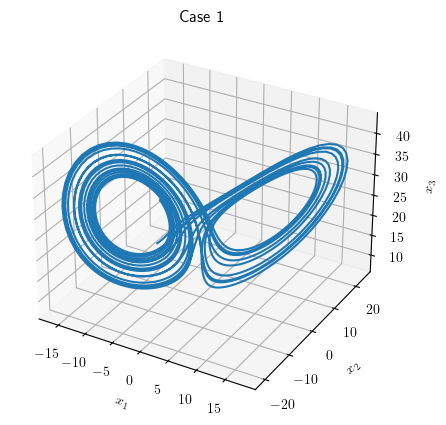

In [15]:
plot_time = 20

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    plot_time=plot_time,)

In [16]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [17]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 100001]


In [18]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [19]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [20]:
all_data = all_data[0:new_bia[-1]]

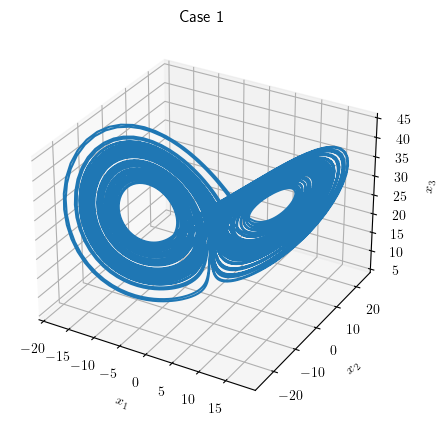

In [21]:
plot_time = 100

plot(
    new_bia,
    delta_t,
    all_data,
    plot_time=plot_time,)

In [22]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [23]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [24]:
normalization_constant_arr_aedata

array([[ 0.1919329 ,  0.19295387, 23.526415  ],
       [23.75482   , 27.052578  , 25.936165  ]], dtype=float32)

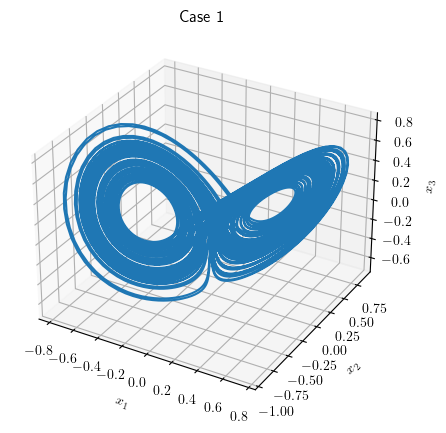

In [25]:
plot_time = 100

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    plot_time=plot_time,)

# Autoencoder

In [26]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.1

# stddev = fRMS*timeMeanofSpaceRMS
contractive_lmda = 0.0
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [27]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = 1 + num_elems_pre_indexing//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [28]:
boundary_idx_arr

array([10001])

In [29]:
all_data.shape

(10001, 3)

In [30]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [31]:
#

In [32]:
# Initialize network
latent_space_dim = 2
# enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
# for i in range(len(enc_layers)):
#     if latent_space_dim < enc_layers[-i-1]:
#         enc_layers = enc_layers[0:-i]
#         break
#     if i == len(enc_layers)-1:
#         enc_layers = []
# dec_layers = enc_layers[::-1]
enc_layers = [8, 8, 4, 4, 2]
dec_layers = [2, 4, 4, 8, 8]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [33]:
#

In [34]:
def optim_func(
        x, # [fRMS, lambda_reg]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        x, # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [35]:
fRMS_bounds = (0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = (1e-6, 1e-3, "log-uniform")
n_calls = 25
acq_func = "EI"
n_initial_points = 5

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0594 - mse: 0.0592 - NMSE: 0.5326 - real_MSE: 0.0592 - params_MSE: nan - ls_jacobian_norm: 0.7313 - tot_time: 0h 0m 3.2s

Epoch 1: val_mse improved from inf to 0.04226, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 3s 10ms/step - loss: 0.0590 - mse: 0.0588 - NMSE: 0.5288 - real_MSE: 0.0588 - params_MSE: nan - ls_jacobian_norm: 0.7275 - val_loss: 0.0425 - val_mse: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0218 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.4931 - val_loss: 0.0027 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
122/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0022 - NMSE: 0.0200 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4778 - tot_time: 0h 0m 24.2s

Epoch 21: val_mse improved from 0.00240 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoin

Epoch 31/200
122/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4582 - tot_time: 0h 0m 34.4s

Epoch 31: val_mse did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0014 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4566 - val_loss: 0.0015 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4624 - tot_time: 0h 0m 35.5s

Epoch 32: val_mse improved from 0.00120 to 0.00111, saving model to /home/rkaushik/Documents/

Epoch 42/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 9.2284e-04 - NMSE: 0.0083 - real_MSE: 9.2284e-04 - params_MSE: nan - ls_jacobian_norm: 0.4924 - tot_time: 0h 0m 45.8s

Epoch 42: val_mse did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0012 - mse: 9.2139e-04 - NMSE: 0.0083 - real_MSE: 9.2139e-04 - params_MSE: nan - ls_jacobian_norm: 0.4937 - val_loss: 0.0010 - val_mse: 7.4379e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4379e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 8.1677e-04 - NMSE: 0.0074 - real_MSE: 8.1677e-04 - params_MSE: nan - ls_jacobian_norm: 0.4899 - tot_time: 0h 0m 46.7s

Epoch 43: val_mse did not improve from 0.00072
 - saving loss 

126/126 [==============================] - ETA: 0s - loss: 0.0011 - mse: 7.9688e-04 - NMSE: 0.0072 - real_MSE: 7.9688e-04 - params_MSE: nan - ls_jacobian_norm: 0.5114 - tot_time: 0h 0m 56.8s

Epoch 53: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - mse: 7.9688e-04 - NMSE: 0.0072 - real_MSE: 7.9688e-04 - params_MSE: nan - ls_jacobian_norm: 0.5110 - val_loss: 0.0010 - val_mse: 7.3531e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3531e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
123/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 7.3222e-04 - NMSE: 0.0066 - real_MSE: 7.3222e-04 - params_MSE: nan - ls_jacobian_norm: 0.5117 - tot_time: 0h 0m 58.0s

Epoch 54: val_mse improved from 0.00067 to 0.00066, saving model to /home/r

Epoch 64/200
126/126 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.3881e-04 - NMSE: 0.0066 - real_MSE: 7.3881e-04 - params_MSE: nan - ls_jacobian_norm: 0.5272 - tot_time: 0h 1m 8.3s

Epoch 64: val_mse improved from 0.00064 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0010 - mse: 7.3881e-04 - NMSE: 0.0066 - real_MSE: 7.3881e-04 - params_MSE: nan - ls_jacobian_norm: 0.5277 - val_loss: 9.0727e-04 - val_mse: 6.3135e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3135e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
123/126 [============================>.] - ETA: 0s - loss: 9.6496e-04 - mse: 6.8903e-04 - NMSE: 0.0062

Epoch 75/200
120/126 [===========================>..] - ETA: 0s - loss: 9.3263e-04 - mse: 6.5631e-04 - NMSE: 0.0059 - real_MSE: 6.5631e-04 - params_MSE: nan - ls_jacobian_norm: 0.5328 - tot_time: 0h 1m 19.5s

Epoch 75: val_mse did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.4035e-04 - mse: 6.6402e-04 - NMSE: 0.0060 - real_MSE: 6.6402e-04 - params_MSE: nan - ls_jacobian_norm: 0.5338 - val_loss: 0.0014 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 76/200
124/126 [============================>.] - ETA: 0s - loss: 9.6294e-04 - mse: 6.8667e-04 - NMSE: 0.0062 - real_MSE: 6.8667e-04 - params_MSE: nan - ls_jacobian_norm: 0.5355 - tot_time: 0h 1m 20.6s

Epoch 76: val_mse did not improve from 0.00057
 - saving l

Epoch 86/200
124/126 [============================>.] - ETA: 0s - loss: 9.5146e-04 - mse: 6.7559e-04 - NMSE: 0.0061 - real_MSE: 6.7559e-04 - params_MSE: nan - ls_jacobian_norm: 0.5413 - tot_time: 0h 1m 30.8s

Epoch 86: val_mse improved from 0.00055 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 9.5008e-04 - mse: 6.7421e-04 - NMSE: 0.0061 - real_MSE: 6.7421e-04 - params_MSE: nan - ls_jacobian_norm: 0.5423 - val_loss: 8.0142e-04 - val_mse: 5.2558e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2558e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 87/200
119/126 [===========================>..] - ETA: 0s - loss: 9.1230e-04 - mse: 6.3645e-04 - NMS

Epoch 97/200
121/126 [===========================>..] - ETA: 0s - loss: 9.2041e-04 - mse: 6.4500e-04 - NMSE: 0.0058 - real_MSE: 6.4500e-04 - params_MSE: nan - ls_jacobian_norm: 0.5439 - tot_time: 0h 1m 42.0s

Epoch 97: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 9.1642e-04 - mse: 6.4101e-04 - NMSE: 0.0058 - real_MSE: 6.4101e-04 - params_MSE: nan - ls_jacobian_norm: 0.5471 - val_loss: 8.2374e-04 - val_mse: 5.4838e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4838e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 98/200
123/126 [============================>.] - ETA: 0s - loss: 8.9665e-04 - mse: 6.2123e-04 - NMSE: 0.0056 - real_MSE: 6.2123e-04 - params_MSE: nan - ls_jacobian_norm: 0.5447 - tot_time: 0h 1m 42.9s

Epoch 98: val_mse did not improve from 0.00052

Epoch 3/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0427 - mse: 0.0391 - NMSE: 0.3517 - real_MSE: 0.0391 - params_MSE: nan - ls_jacobian_norm: 0.5947 - tot_time: 0h 0m 5.4s

Epoch 3: val_mse improved from 0.04037 to 0.02916, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0424 - mse: 0.0388 - NMSE: 0.3488 - real_MSE: 0.0388 - params_MSE: nan - ls_jacobian_norm: 0.6090 - val_loss: 0.0329 - val_mse: 0.0292 - val_NMSE: 0.2624 - val_real_MSE: 0.0292 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0194 - mse: 0.0155 - NMSE: 0.1398 - real_MSE: 0.0155 - params_MSE: nan 

Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 0.0078 - mse: 0.0043 - NMSE: 0.0385 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.5259 - tot_time: 0h 0m 16.3s

Epoch 13: val_mse did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0078 - mse: 0.0043 - NMSE: 0.0385 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.5250 - val_loss: 0.0079 - val_mse: 0.0044 - val_NMSE: 0.0393 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0077 - mse: 0.0042 - NMSE: 0.0376 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.5361 - tot_time: 0h 0m 17.1s

Epoch 14: val_mse did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0061 - mse: 0.0027 - NMSE: 0.0239 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5178 - val_loss: 0.0060 - val_mse: 0.0026 - val_NMSE: 0.0231 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
126/126 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0026 - NMSE: 0.0232 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.5069 - tot_time: 0h 0m 27.9s

Epoch 24: val_mse improved from 0.00257 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoin

Epoch 34/200
126/126 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4610 - tot_time: 0h 0m 38.2s

Epoch 34: val_mse improved from 0.00167 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0049 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4610 - val_loss: 0.0048 - val_mse: 0.0014 - val_NMSE: 0.0129 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0048 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: n

Epoch 45/200
126/126 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4901 - tot_time: 0h 0m 49.5s

Epoch 45: val_mse did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0043 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4896 - val_loss: 0.0047 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0043 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4991 - tot_time: 0h 0m 50.3s

Epoch 46: val_mse did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Docu

Epoch 56/200
125/126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 9.4951e-04 - NMSE: 0.0085 - real_MSE: 9.4951e-04 - params_MSE: nan - ls_jacobian_norm: 0.5196 - tot_time: 0h 1m 0.4s

Epoch 56: val_mse did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0041 - mse: 9.4951e-04 - NMSE: 0.0085 - real_MSE: 9.4951e-04 - params_MSE: nan - ls_jacobian_norm: 0.5195 - val_loss: 0.0040 - val_mse: 9.1169e-04 - val_NMSE: 0.0082 - val_real_MSE: 9.1169e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57/200
122/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 9.4534e-04 - NMSE: 0.0085 - real_MSE: 9.4534e-04 - params_MSE: nan - ls_jacobian_norm: 0.5213 - tot_time: 0h 1m 1.4s

Epoch 57: val_mse did not improve from 0.00088
 - saving loss hi

123/126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 8.8760e-04 - NMSE: 0.0080 - real_MSE: 8.8760e-04 - params_MSE: nan - ls_jacobian_norm: 0.5383 - tot_time: 0h 1m 11.4s

Epoch 67: val_mse did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0039 - mse: 8.8931e-04 - NMSE: 0.0080 - real_MSE: 8.8931e-04 - params_MSE: nan - ls_jacobian_norm: 0.5393 - val_loss: 0.0041 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 68/200
125/126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 8.9132e-04 - NMSE: 0.0080 - real_MSE: 8.9132e-04 - params_MSE: nan - ls_jacobian_norm: 0.5406 - tot_time: 0h 1m 12.4s

Epoch 68: val_mse did not improve from 0.00076
 - saving loss histories at /home/rk

Epoch 7/200
122/126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 8.5290e-04 - NMSE: 0.0077 - real_MSE: 8.5290e-04 - params_MSE: nan - ls_jacobian_norm: 0.5300 - tot_time: 0h 1m 22.4s

Epoch 7: val_mse did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0039 - mse: 8.5117e-04 - NMSE: 0.0077 - real_MSE: 8.5117e-04 - params_MSE: nan - ls_jacobian_norm: 0.5307 - val_loss: 0.0038 - val_mse: 7.5897e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5897e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
126/126 [==============================] - ETA: 0s - loss: 0.0039 - mse: 8.4849e-04 - NMSE: 0.0076 - real_MSE: 8.4849e-04 - params_MSE: nan - ls_jacobian_norm: 0.5298 - tot_time: 0h 1m 23.4s

Epoch 8: val_mse did not improve from 0.00075
 - saving loss hist

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0130 - mse: 0.0129 - NMSE: 0.1162 - real_MSE: 0.0129 - params_MSE: nan - ls_jacobian_norm: 1.0100 - val_loss: 0.0078 - val_mse: 0.0077 - val_NMSE: 0.0692 - val_real_MSE: 0.0077 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
122/126 [============================>.] - ETA: 0s - loss: 0.0069 - mse: 0.0067 - NMSE: 0.0607 - real_MSE: 0.0067 - params_MSE: nan - ls_jacobian_norm: 0.8251 - tot_time: 0h 0m 7.0s

Epoch 5: val_mse improved from 0.00769 to 0.00588, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/

Epoch 15/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0035 - mse: 0.0033 - NMSE: 0.0299 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5536 - tot_time: 0h 0m 17.2s

Epoch 15: val_mse improved from 0.00394 to 0.00315, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0034 - mse: 0.0033 - NMSE: 0.0298 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5530 - val_loss: 0.0033 - val_mse: 0.0031 - val_NMSE: 0.0283 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
126/126 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0030 - NMSE: 0.0266 - real_MSE: 0.0030 - params_MSE: n

Epoch 25/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4416 - tot_time: 0h 0m 27.4s

Epoch 25: val_mse improved from 0.00137 to 0.00118, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4407 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0106 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 9.3452e-04 - mse: 7.8063e-04 - NMSE: 0.0070 - real_MSE: 7.8063e-04 - params_MSE: nan - ls_jacobian_norm: 0.4723 - val_loss: 0.0039 - val_mse: 0.0037 - val_NMSE: 0.0334 - val_real_MSE: 0.0037 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
124/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 9.5023e-04 - NMSE: 0.0086 - real_MSE: 9.5023e-04 - params_MSE: nan - ls_jacobian_norm: 0.4788 - tot_time: 0h 0m 38.2s

Epoch 36: val_mse improved from 0.00083 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/t

Epoch 46/200
126/126 [==============================] - ETA: 0s - loss: 7.7619e-04 - mse: 6.1933e-04 - NMSE: 0.0056 - real_MSE: 6.1933e-04 - params_MSE: nan - ls_jacobian_norm: 0.5035 - tot_time: 0h 0m 48.0s

Epoch 46: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 7.7619e-04 - mse: 6.1933e-04 - NMSE: 0.0056 - real_MSE: 6.1933e-04 - params_MSE: nan - ls_jacobian_norm: 0.5026 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0104 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
123/126 [============================>.] - ETA: 0s - loss: 7.7661e-04 - mse: 6.1952e-04 - NMSE: 0.0056 - real_MSE: 6.1952e-04 - params_MSE: nan - ls_jacobian_norm: 0.5058 - tot_time: 0h 0m 48.9s

Epoch 47: val_mse did not improve from 0.00067
 - saving l

Epoch 57/200
124/126 [============================>.] - ETA: 0s - loss: 6.9805e-04 - mse: 5.3846e-04 - NMSE: 0.0048 - real_MSE: 5.3846e-04 - params_MSE: nan - ls_jacobian_norm: 0.5317 - tot_time: 0h 0m 58.7s

Epoch 57: val_mse improved from 0.00067 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.9646e-04 - mse: 5.3688e-04 - NMSE: 0.0048 - real_MSE: 5.3688e-04 - params_MSE: nan - ls_jacobian_norm: 0.5303 - val_loss: 7.4936e-04 - val_mse: 5.8965e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8965e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
123/126 [============================>.] - ETA: 0s - loss: 6.5875e-04 - mse: 4.9894e-04 - NMS

Epoch 68/200
121/126 [===========================>..] - ETA: 0s - loss: 6.3941e-04 - mse: 4.7815e-04 - NMSE: 0.0043 - real_MSE: 4.7815e-04 - params_MSE: nan - ls_jacobian_norm: 0.5465 - tot_time: 0h 1m 9.7s

Epoch 68: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.3516e-04 - mse: 4.7390e-04 - NMSE: 0.0043 - real_MSE: 4.7390e-04 - params_MSE: nan - ls_jacobian_norm: 0.5454 - val_loss: 0.0016 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 69/200
126/126 [==============================] - ETA: 0s - loss: 6.9947e-04 - mse: 5.3823e-04 - NMSE: 0.0048 - real_MSE: 5.3823e-04 - params_MSE: nan - ls_jacobian_norm: 0.5477 - tot_time: 0h 1m 10.9s

Epoch 69: val_mse did not improve from 0.00051
 - saving lo

Epoch 2/200
126/126 [==============================] - ETA: 0s - loss: 5.8868e-04 - mse: 4.2744e-04 - NMSE: 0.0038 - real_MSE: 4.2744e-04 - params_MSE: nan - ls_jacobian_norm: 0.5451 - tot_time: 0h 1m 20.6s

Epoch 2: val_mse improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 5.8868e-04 - mse: 4.2744e-04 - NMSE: 0.0038 - real_MSE: 4.2744e-04 - params_MSE: nan - ls_jacobian_norm: 0.5448 - val_loss: 6.0920e-04 - val_mse: 4.4794e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4794e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
124/126 [============================>.] - ETA: 0s - loss: 5.9109e-04 - mse: 4.2982e-04 - NMSE: 

Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 5.8707e-04 - mse: 4.2551e-04 - NMSE: 0.0038 - real_MSE: 4.2551e-04 - params_MSE: nan - ls_jacobian_norm: 0.5444 - tot_time: 0h 1m 31.6s

Epoch 13: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.8702e-04 - mse: 4.2546e-04 - NMSE: 0.0038 - real_MSE: 4.2546e-04 - params_MSE: nan - ls_jacobian_norm: 0.5441 - val_loss: 6.0395e-04 - val_mse: 4.4236e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4236e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 5.8662e-04 - mse: 4.2501e-04 - NMSE: 0.0038 - real_MSE: 4.2501e-04 - params_MSE: nan - ls_jacobian_norm: 0.5442 - tot_time: 0h 1m 32.5s

Epoch 14: val_mse did not improve from 0.00044

Epoch 13/200
122/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 0.0040 - NMSE: 0.0356 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 0.5219 - tot_time: 0h 0m 15.3s

Epoch 13: val_mse improved from 0.00409 to 0.00396, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0046 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.5213 - val_loss: 0.0046 - val_mse: 0.0040 - val_NMSE: 0.0356 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0044 - mse: 0.0037 - NMSE: 0.0336 - real_MSE: 0.0037 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0016 - mse: 8.6450e-04 - NMSE: 0.0078 - real_MSE: 8.6450e-04 - params_MSE: nan - ls_jacobian_norm: 0.4602 - val_loss: 0.0016 - val_mse: 8.9345e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.9345e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 8.2237e-04 - NMSE: 0.0074 - real_MSE: 8.2237e-04 - params_MSE: nan - ls_jacobian_norm: 0.4636 - tot_time: 0h 0m 36.7s

Epoch 34: val_mse improved from 0.00089 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_

Epoch 44/200
124/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 6.6923e-04 - NMSE: 0.0060 - real_MSE: 6.6923e-04 - params_MSE: nan - ls_jacobian_norm: 0.4886 - tot_time: 0h 0m 46.8s

Epoch 44: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0014 - mse: 6.6955e-04 - NMSE: 0.0060 - real_MSE: 6.6955e-04 - params_MSE: nan - ls_jacobian_norm: 0.4882 - val_loss: 0.0015 - val_mse: 7.7392e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.7392e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 45/200
123/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 6.6175e-04 - NMSE: 0.0060 - real_MSE: 6.6175e-04 - params_MSE: nan - ls_jacobian_norm: 0.4890 - tot_time: 0h 0m 47.8s

Epoch 45: val_mse did not improve from 0.00069
 - saving loss 

Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 6.3627e-04 - NMSE: 0.0057 - real_MSE: 6.3627e-04 - params_MSE: nan - ls_jacobian_norm: 0.4869 - tot_time: 0h 0m 58.0s

Epoch 2: val_mse improved from 0.00065 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0014 - mse: 6.3804e-04 - NMSE: 0.0057 - real_MSE: 6.3804e-04 - params_MSE: nan - ls_jacobian_norm: 0.4863 - val_loss: 0.0014 - val_mse: 6.3899e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.3899e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
124/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 6.3597e-04 - NMSE: 0.0057 - real_MS

Epoch 13/200
126/126 [==============================] - ETA: 0s - loss: 0.0014 - mse: 6.1935e-04 - NMSE: 0.0056 - real_MSE: 6.1935e-04 - params_MSE: nan - ls_jacobian_norm: 0.4877 - tot_time: 0h 1m 9.1s

Epoch 13: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0014 - mse: 6.1935e-04 - NMSE: 0.0056 - real_MSE: 6.1935e-04 - params_MSE: nan - ls_jacobian_norm: 0.4880 - val_loss: 0.0014 - val_mse: 6.3091e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3091e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 6.2104e-04 - NMSE: 0.0056 - real_MSE: 6.2104e-04 - params_MSE: nan - ls_jacobian_norm: 0.4876 - tot_time: 0h 1m 10.0s

Epoch 14: val_mse did not improve from 0.00063
 - saving loss h

Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 6.0197e-04 - NMSE: 0.0054 - real_MSE: 6.0197e-04 - params_MSE: nan - ls_jacobian_norm: 0.4888 - tot_time: 0h 1m 20.2s

Epoch 24: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0013 - mse: 6.0056e-04 - NMSE: 0.0054 - real_MSE: 6.0056e-04 - params_MSE: nan - ls_jacobian_norm: 0.4894 - val_loss: 0.0014 - val_mse: 6.2171e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2171e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
123/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 5.9269e-04 - NMSE: 0.0053 - real_MSE: 5.9269e-04 - params_MSE: nan - ls_jacobian_norm: 0.4886 - tot_time: 0h 1m 21.1s

Epoch 25: val_mse improved from 0.00061 to 0.00060, saving mod

Epoch 35/200
124/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 5.7967e-04 - NMSE: 0.0052 - real_MSE: 5.7967e-04 - params_MSE: nan - ls_jacobian_norm: 0.4896 - tot_time: 0h 1m 31.2s

Epoch 35: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - mse: 5.7894e-04 - NMSE: 0.0052 - real_MSE: 5.7894e-04 - params_MSE: nan - ls_jacobian_norm: 0.4900 - val_loss: 0.0014 - val_mse: 6.6007e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.6007e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
122/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 5.9535e-04 - NMSE: 0.0054 - real_MSE: 5.9535e-04 - params_MSE: nan - ls_jacobian_norm: 0.4899 - tot_time: 0h 1m 32.3s

Epoch 36: val_mse improved from 0.00059 to 0.00058, saving mod

Epoch 46/200
123/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 5.6222e-04 - NMSE: 0.0051 - real_MSE: 5.6222e-04 - params_MSE: nan - ls_jacobian_norm: 0.4927 - tot_time: 0h 1m 42.5s

Epoch 46: val_mse did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0013 - mse: 5.6016e-04 - NMSE: 0.0050 - real_MSE: 5.6016e-04 - params_MSE: nan - ls_jacobian_norm: 0.4910 - val_loss: 0.0013 - val_mse: 5.8164e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8164e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 5.5999e-04 - NMSE: 0.0050 - real_MSE: 5.5999e-04 - params_MSE: nan - ls_jacobian_norm: 0.4924 - tot_time: 0h 1m 43.4s

Epoch 47: val_mse improved from 0.00057 to 0.00056, saving mod

Epoch 57/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 5.4508e-04 - NMSE: 0.0049 - real_MSE: 5.4508e-04 - params_MSE: nan - ls_jacobian_norm: 0.4944 - tot_time: 0h 1m 53.8s

Epoch 57: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0013 - mse: 5.4103e-04 - NMSE: 0.0049 - real_MSE: 5.4103e-04 - params_MSE: nan - ls_jacobian_norm: 0.4930 - val_loss: 0.0013 - val_mse: 5.5730e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5730e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
125/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 5.3759e-04 - NMSE: 0.0048 - real_MSE: 5.3759e-04 - params_MSE: nan - ls_jacobian_norm: 0.4946 - tot_time: 0h 1m 54.9s

Epoch 58: val_mse did not improve from 0.00055
 - saving loss 

Epoch 78/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 5.1120e-04 - NMSE: 0.0046 - real_MSE: 5.1120e-04 - params_MSE: nan - ls_jacobian_norm: 0.5005 - tot_time: 0h 2m 15.0s

Epoch 78: val_mse improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 5.1477e-04 - NMSE: 0.0046 - real_MSE: 5.1477e-04 - params_MSE: nan - ls_jacobian_norm: 0.4991 - val_loss: 0.0013 - val_mse: 5.2526e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2526e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 79/200
123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 5.0905e-04 - NMSE: 0.0046 - real

Epoch 99/200
125/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.8289e-04 - NMSE: 0.0043 - real_MSE: 4.8289e-04 - params_MSE: nan - ls_jacobian_norm: 0.5045 - tot_time: 0h 2m 36.5s

Epoch 99: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0012 - mse: 4.8283e-04 - NMSE: 0.0043 - real_MSE: 4.8283e-04 - params_MSE: nan - ls_jacobian_norm: 0.5049 - val_loss: 0.0012 - val_mse: 5.0466e-04 - val_NMSE: 0.0045 - val_real_MSE: 5.0466e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 100/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 4.8252e-04 - NMSE: 0.0043 - real_MSE: 4.8252e-04 - params_MSE: nan - ls_jacobian_norm: 0.5046 - tot_time: 0h 2m 37.5s

Epoch 100: val_mse did not improve from 0.00050
 - saving los

Epoch 110/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 5.1984e-04 - NMSE: 0.0047 - real_MSE: 5.1984e-04 - params_MSE: nan - ls_jacobian_norm: 0.5101 - tot_time: 0h 2m 47.8s

Epoch 110: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0012 - mse: 5.1346e-04 - NMSE: 0.0046 - real_MSE: 5.1346e-04 - params_MSE: nan - ls_jacobian_norm: 0.5110 - val_loss: 0.0012 - val_mse: 4.8918e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8918e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 111/200
122/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.7531e-04 - NMSE: 0.0043 - real_MSE: 4.7531e-04 - params_MSE: nan - ls_jacobian_norm: 0.5101 - tot_time: 0h 2m 48.9s

Epoch 111: val_mse improved from 0.00049 to 0.00048, saving

Epoch 121/200
126/126 [==============================] - ETA: 0s - loss: 0.0012 - mse: 4.6468e-04 - NMSE: 0.0042 - real_MSE: 4.6468e-04 - params_MSE: nan - ls_jacobian_norm: 0.5109 - tot_time: 0h 2m 59.1s

Epoch 121: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 4.6468e-04 - NMSE: 0.0042 - real_MSE: 4.6468e-04 - params_MSE: nan - ls_jacobian_norm: 0.5107 - val_loss: 0.0012 - val_mse: 4.8004e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.8004e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 122/200
123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.6107e-04 - NMSE: 0.0041 - real_MSE: 4.6107e-04 - params_MSE: nan - ls_jacobian_norm: 0.5116 - tot_time: 0h 3m 0.3s

Epoch 122: val_mse improved from 0.00048 to 0.00047, saving 

Epoch 132/200
125/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.7202e-04 - NMSE: 0.0042 - real_MSE: 4.7202e-04 - params_MSE: nan - ls_jacobian_norm: 0.5135 - tot_time: 0h 3m 10.3s

Epoch 132: val_mse improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0012 - mse: 4.7196e-04 - NMSE: 0.0042 - real_MSE: 4.7196e-04 - params_MSE: nan - ls_jacobian_norm: 0.5129 - val_loss: 0.0012 - val_mse: 4.7329e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7329e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 133/200
122/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.5800e-04 - NMSE: 0.0041 - r

Epoch 143/200
122/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.4950e-04 - NMSE: 0.0040 - real_MSE: 4.4950e-04 - params_MSE: nan - ls_jacobian_norm: 0.5149 - tot_time: 0h 3m 21.6s

Epoch 143: val_mse improved from 0.00047 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 4.4836e-04 - NMSE: 0.0040 - real_MSE: 4.4836e-04 - params_MSE: nan - ls_jacobian_norm: 0.5136 - val_loss: 0.0012 - val_mse: 4.5945e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5945e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 144/200
123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.4878e-04 - NMSE: 0.0040 - r

Epoch 154/200
124/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.4360e-04 - NMSE: 0.0040 - real_MSE: 4.4360e-04 - params_MSE: nan - ls_jacobian_norm: 0.5168 - tot_time: 0h 3m 33.0s

Epoch 154: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0012 - mse: 4.4158e-04 - NMSE: 0.0040 - real_MSE: 4.4158e-04 - params_MSE: nan - ls_jacobian_norm: 0.5194 - val_loss: 0.0012 - val_mse: 4.6392e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6392e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 155/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 4.4437e-04 - NMSE: 0.0040 - real_MSE: 4.4437e-04 - params_MSE: nan - ls_jacobian_norm: 0.5172 - tot_time: 0h 3m 34.0s

Epoch 155: val_mse did not improve from 0.00046
 - saving l

Epoch 165/200
126/126 [==============================] - ETA: 0s - loss: 0.0012 - mse: 4.3586e-04 - NMSE: 0.0039 - real_MSE: 4.3586e-04 - params_MSE: nan - ls_jacobian_norm: 0.5185 - tot_time: 0h 3m 44.2s

Epoch 165: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0012 - mse: 4.3586e-04 - NMSE: 0.0039 - real_MSE: 4.3586e-04 - params_MSE: nan - ls_jacobian_norm: 0.5187 - val_loss: 0.0012 - val_mse: 4.6854e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6854e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 166/200
124/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 4.3531e-04 - NMSE: 0.0039 - real_MSE: 4.3531e-04 - params_MSE: nan - ls_jacobian_norm: 0.5186 - tot_time: 0h 3m 45.1s

Epoch 166: val_mse did not improve from 0.00045
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0012 - mse: 4.3150e-04 - NMSE: 0.0039 - real_MSE: 4.3150e-04 - params_MSE: nan - ls_jacobian_norm: 0.5194 - val_loss: 0.0012 - val_mse: 4.5452e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5452e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 176/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 4.2919e-04 - NMSE: 0.0039 - real_MSE: 4.2919e-04 - params_MSE: nan - ls_jacobian_norm: 0.5201 - tot_time: 0h 3m 55.4s

Epoch 176: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 4.2927e-04 - NMSE: 

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz/tools/misc_tools.py:884: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0651 - mse: 0.0598 - NMSE: 0.5383 - real_MSE: 0.0598 - params_MSE: nan - ls_jacobian_norm: 0.7339 - tot_time: 0h 0m 2.8s

Epoch 1: val_mse improved from inf to 0.04229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 3s 9ms/step - loss: 0.0640 - mse: 0.0588 - NMSE: 0.5289 - real_MSE: 0.0588 - params_MSE: nan - ls_jacobian_norm: 0.7271 - val_loss: 0.0476 - val_mse: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0100 - mse: 0.0049 - NMSE: 0.0437 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.5751 - val_loss: 0.0097 - val_mse: 0.0046 - val_NMSE: 0.0416 - val_real_MSE: 0.0046 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
124/126 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0047 - NMSE: 0.0422 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.5524 - tot_time: 0h 0m 11.8s

Epoch 10: val_mse did not improve from 0.00462
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0097 - mse: 0.0047 - NMSE: 0.0422 - real_MSE: 0.0047 - pa

126/126 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0025 - NMSE: 0.0222 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5101 - tot_time: 0h 0m 30.9s

Epoch 29: val_mse did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0067 - mse: 0.0025 - NMSE: 0.0222 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5099 - val_loss: 0.0068 - val_mse: 0.0027 - val_NMSE: 0.0239 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
123/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0024 - NMSE: 0.0219 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.5067 - tot_time: 0h 0m 31.9s

Epoch 30: val_mse did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/

Epoch 40/200
122/126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 0.0018 - NMSE: 0.0165 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.5108 - tot_time: 0h 0m 41.9s

Epoch 40: val_mse did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0059 - mse: 0.0018 - NMSE: 0.0165 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.5109 - val_loss: 0.0062 - val_mse: 0.0022 - val_NMSE: 0.0194 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0058 - mse: 0.0018 - NMSE: 0.0161 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.5130 - tot_time: 0h 0m 42.9s

Epoch 41: val_mse improved from 0.00198 to 0.00185, saving model to /home/rkaushik/Documents/T

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0052 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.5343 - val_loss: 0.0053 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0052 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.5372 - tot_time: 0h 0m 53.1s

Epoch 51: val_mse improved from 0.00114 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoin

Epoch 72/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0047 - mse: 8.1830e-04 - NMSE: 0.0074 - real_MSE: 8.1830e-04 - params_MSE: nan - ls_jacobian_norm: 0.5802 - tot_time: 0h 1m 13.9s

Epoch 72: val_mse improved from 0.00082 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0047 - mse: 8.1826e-04 - NMSE: 0.0074 - real_MSE: 8.1826e-04 - params_MSE: nan - ls_jacobian_norm: 0.5789 - val_loss: 0.0047 - val_mse: 8.1875e-04 - val_NMSE: 0.0074 - val_real_MSE: 8.1875e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 73/200
122/126 [============================>.] - ETA: 0s - loss: 0.0047 - mse: 8.0930e-04 - NMSE: 0.0073 - real

Epoch 83/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0047 - mse: 8.0079e-04 - NMSE: 0.0072 - real_MSE: 8.0079e-04 - params_MSE: nan - ls_jacobian_norm: 0.6004 - tot_time: 0h 1m 24.6s

Epoch 83: val_mse did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0046 - mse: 7.9102e-04 - NMSE: 0.0071 - real_MSE: 7.9102e-04 - params_MSE: nan - ls_jacobian_norm: 0.5998 - val_loss: 0.0046 - val_mse: 7.8377e-04 - val_NMSE: 0.0071 - val_real_MSE: 7.8377e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 84/200
125/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 7.5762e-04 - NMSE: 0.0068 - real_MSE: 7.5762e-04 - params_MSE: nan - ls_jacobian_norm: 0.6015 - tot_time: 0h 1m 25.6s

Epoch 84: val_mse did not improve from 0.00078
 - saving loss 

Epoch 15/200
126/126 [==============================] - ETA: 0s - loss: 0.0046 - mse: 7.4387e-04 - NMSE: 0.0067 - real_MSE: 7.4387e-04 - params_MSE: nan - ls_jacobian_norm: 0.5961 - tot_time: 0h 1m 45.4s

Epoch 15: val_mse did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0046 - mse: 7.4387e-04 - NMSE: 0.0067 - real_MSE: 7.4387e-04 - params_MSE: nan - ls_jacobian_norm: 0.5957 - val_loss: 0.0046 - val_mse: 7.6197e-04 - val_NMSE: 0.0069 - val_real_MSE: 7.6197e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
123/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 7.3809e-04 - NMSE: 0.0066 - real_MSE: 7.3809e-04 - params_MSE: nan - ls_jacobian_norm: 0.5960 - tot_time: 0h 1m 46.4s

Epoch 16: val_mse improved from 0.00076 to 0.00076, saving mod

Epoch 26/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 7.2981e-04 - NMSE: 0.0066 - real_MSE: 7.2981e-04 - params_MSE: nan - ls_jacobian_norm: 0.5975 - tot_time: 0h 1m 56.1s

Epoch 26: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0046 - mse: 7.2991e-04 - NMSE: 0.0066 - real_MSE: 7.2991e-04 - params_MSE: nan - ls_jacobian_norm: 0.5975 - val_loss: 0.0046 - val_mse: 7.4867e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4867e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
124/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 7.2834e-04 - NMSE: 0.0066 - real_MSE: 7.2834e-04 - params_MSE: nan - ls_jacobian_norm: 0.5977 - tot_time: 0h 1m 57.2s

Epoch 27: val_mse did not improve from 0.00074
 - saving loss 

Epoch 37/200
123/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 7.1892e-04 - NMSE: 0.0065 - real_MSE: 7.1892e-04 - params_MSE: nan - ls_jacobian_norm: 0.5997 - tot_time: 0h 2m 7.4s

Epoch 37: val_mse did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0046 - mse: 7.2321e-04 - NMSE: 0.0065 - real_MSE: 7.2321e-04 - params_MSE: nan - ls_jacobian_norm: 0.5980 - val_loss: 0.0046 - val_mse: 7.4557e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4557e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 7.2050e-04 - NMSE: 0.0065 - real_MSE: 7.2050e-04 - params_MSE: nan - ls_jacobian_norm: 0.5996 - tot_time: 0h 2m 8.2s

Epoch 38: val_mse did not improve from 0.00073
 - saving loss hi



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0668 - mse: 0.0592 - NMSE: 0.5329 - real_MSE: 0.0592 - params_MSE: nan - ls_jacobian_norm: 0.7304 - tot_time: 0h 0m 2.7s

Epoch 1: val_mse improved from inf to 0.04230, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 3s 8ms/step - loss: 0.0663 - mse: 0.0588 - NMSE: 0.5291 - real_MSE: 0.0588 - params_MSE: nan - ls_jacobian_norm: 0.7266 - val_loss: 0.0498 - val_mse: 0.0

Epoch 21/200
124/126 [============================>.] - ETA: 0s - loss: 0.0090 - mse: 0.0032 - NMSE: 0.0288 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5700 - tot_time: 0h 0m 23.3s

Epoch 21: val_mse improved from 0.00343 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0090 - mse: 0.0032 - NMSE: 0.0288 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5693 - val_loss: 0.0090 - val_mse: 0.0032 - val_NMSE: 0.0288 - val_real_MSE: 0.0032 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
125/126 [============================>.] - ETA: 0s - loss: 0.0089 - mse: 0.0031 - NMSE: 0.0280 - real_MSE: 0.0031 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0080 - mse: 0.0027 - NMSE: 0.0244 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5324 - val_loss: 0.0083 - val_mse: 0.0031 - val_NMSE: 0.0277 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
126/126 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0027 - NMSE: 0.0242 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5387 - tot_time: 0h 0m 34.7s

Epoch 32: val_mse improved from 0.00287 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0074 - mse: 0.0025 - NMSE: 0.0223 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5506 - val_loss: 0.0075 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0074 - mse: 0.0025 - NMSE: 0.0222 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5525 - tot_time: 0h 0m 45.6s

Epoch 43: val_mse improved from 0.00250 to 0.00247, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0068 - mse: 0.0018 - NMSE: 0.0160 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6013 - val_loss: 0.0069 - val_mse: 0.0019 - val_NMSE: 0.0167 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
123/126 [============================>.] - ETA: 0s - loss: 0.0068 - mse: 0.0017 - NMSE: 0.0156 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6062 - tot_time: 0h 1m 6.8s

Epoch 64: val_mse improved from 0.00186 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0063 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6397 - val_loss: 0.0063 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 84/200
126/126 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6431 - tot_time: 0h 1m 27.2s

Epoch 84: val_mse did not improve from 0.00104
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0062 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - pa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0061 - mse: 9.6292e-04 - NMSE: 0.0087 - real_MSE: 9.6292e-04 - params_MSE: nan - ls_jacobian_norm: 0.6622 - val_loss: 0.0062 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 95/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0061 - mse: 9.7175e-04 - NMSE: 0.0087 - real_MSE: 9.7175e-04 - params_MSE: nan - ls_jacobian_norm: 0.6631 - tot_time: 0h 1m 38.2s

Epoch 95: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0061 - mse: 9.6757e-04 - NMSE: 0.0087 - r

Epoch 6/200
126/126 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.5021e-04 - NMSE: 0.0086 - real_MSE: 9.5021e-04 - params_MSE: nan - ls_jacobian_norm: 0.6530 - tot_time: 0h 1m 48.2s

Epoch 6: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0061 - mse: 9.5021e-04 - NMSE: 0.0086 - real_MSE: 9.5021e-04 - params_MSE: nan - ls_jacobian_norm: 0.6527 - val_loss: 0.0061 - val_mse: 9.5523e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5523e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
125/126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 9.4775e-04 - NMSE: 0.0085 - real_MS

Epoch 17/200
123/126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 9.4211e-04 - NMSE: 0.0085 - real_MSE: 9.4211e-04 - params_MSE: nan - ls_jacobian_norm: 0.6533 - tot_time: 0h 1m 59.2s

Epoch 17: val_mse did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0061 - mse: 9.4010e-04 - NMSE: 0.0085 - real_MSE: 9.4010e-04 - params_MSE: nan - ls_jacobian_norm: 0.6517 - val_loss: 0.0061 - val_mse: 9.4943e-04 - val_NMSE: 0.0085 - val_real_MSE: 9.4943e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0061 - mse: 9.3133e-04 - NMSE: 0.0084 - real_MSE: 9.3133e-04 - params_MSE: nan - ls_jacobian_norm: 0.6531 - tot_time: 0h 2m 0.1s

Epoch 18: val_mse did not improve from 0.00095
 - saving loss h

Epoch 28/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0061 - mse: 9.2978e-04 - NMSE: 0.0084 - real_MSE: 9.2978e-04 - params_MSE: nan - ls_jacobian_norm: 0.6559 - tot_time: 0h 2m 9.8s

Epoch 28: val_mse improved from 0.00094 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0061 - mse: 9.2981e-04 - NMSE: 0.0084 - real_MSE: 9.2981e-04 - params_MSE: nan - ls_jacobian_norm: 0.6552 - val_loss: 0.0061 - val_mse: 9.3284e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3284e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0061 - mse: 9.2305e-04 - NMSE: 0.0083 - real_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0061 - mse: 9.1963e-04 - NMSE: 0.0083 - real_MSE: 9.1963e-04 - params_MSE: nan - ls_jacobian_norm: 0.6586 - val_loss: 0.0061 - val_mse: 9.2139e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.2139e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
126/126 [==============================] - ETA: 0s - loss: 0.0061 - mse: 9.2148e-04 - NMSE: 0.0083 - real_MSE: 9.2148e-04 - params_MSE: nan - ls_jacobian_norm: 0.6582 - tot_time: 0h 2m 20.6s

Epoch 39: val_mse did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0061 - mse: 9.2148e-04 - NMSE: 0.

Epoch 49/200
122/126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 9.1134e-04 - NMSE: 0.0082 - real_MSE: 9.1134e-04 - params_MSE: nan - ls_jacobian_norm: 0.6602 - tot_time: 0h 2m 30.3s

Epoch 49: val_mse did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0061 - mse: 9.1120e-04 - NMSE: 0.0082 - real_MSE: 9.1120e-04 - params_MSE: nan - ls_jacobian_norm: 0.6614 - val_loss: 0.0061 - val_mse: 9.2144e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.2144e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
124/126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 9.1318e-04 - NMSE: 0.0082 - real_MSE: 9.1318e-04 - params_MSE: nan - ls_jacobian_norm: 0.6609 - tot_time: 0h 2m 31.2s

Epoch 50: val_mse did not improve from 0.00091
 - saving loss 

Epoch 60/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 9.0026e-04 - NMSE: 0.0081 - real_MSE: 9.0026e-04 - params_MSE: nan - ls_jacobian_norm: 0.6642 - tot_time: 0h 2m 41.1s

Epoch 60: val_mse did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 9.0102e-04 - NMSE: 0.0081 - real_MSE: 9.0102e-04 - params_MSE: nan - ls_jacobian_norm: 0.6642 - val_loss: 0.0060 - val_mse: 9.1223e-04 - val_NMSE: 0.0082 - val_real_MSE: 9.1223e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 9.0221e-04 - NMSE: 0.0081 - real_MSE: 9.0221e-04 - params_MSE: nan - ls_jacobian_norm: 0.6640 - tot_time: 0h 2m 42.0s

Epoch 61: val_mse did not improve from 0.00090
 - saving loss 

Epoch 71/200
123/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.9651e-04 - NMSE: 0.0081 - real_MSE: 8.9651e-04 - params_MSE: nan - ls_jacobian_norm: 0.6680 - tot_time: 0h 2m 51.5s

Epoch 71: val_mse improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0060 - mse: 8.9727e-04 - NMSE: 0.0081 - real_MSE: 8.9727e-04 - params_MSE: nan - ls_jacobian_norm: 0.6661 - val_loss: 0.0060 - val_mse: 8.9650e-04 - val_NMSE: 0.0081 - val_real_MSE: 8.9650e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
125/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.9516e-04 - NMSE: 0.0081 - real

Epoch 82/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.8834e-04 - NMSE: 0.0080 - real_MSE: 8.8834e-04 - params_MSE: nan - ls_jacobian_norm: 0.6714 - tot_time: 0h 3m 2.5s

Epoch 82: val_mse did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0060 - mse: 8.8750e-04 - NMSE: 0.0080 - real_MSE: 8.8750e-04 - params_MSE: nan - ls_jacobian_norm: 0.6689 - val_loss: 0.0060 - val_mse: 9.0126e-04 - val_NMSE: 0.0081 - val_real_MSE: 9.0126e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
125/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.9207e-04 - NMSE: 0.0080 - real_MSE: 8.9207e-04 - params_MSE: nan - ls_jacobian_norm: 0.6713 - tot_time: 0h 3m 3.6s

Epoch 83: val_mse improved from 0.00089 to 0.00089, saving model

Epoch 93/200
126/126 [==============================] - ETA: 0s - loss: 0.0060 - mse: 8.7983e-04 - NMSE: 0.0079 - real_MSE: 8.7983e-04 - params_MSE: nan - ls_jacobian_norm: 0.6725 - tot_time: 0h 3m 13.4s

Epoch 93: val_mse did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 8.7983e-04 - NMSE: 0.0079 - real_MSE: 8.7983e-04 - params_MSE: nan - ls_jacobian_norm: 0.6715 - val_loss: 0.0060 - val_mse: 8.8469e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.8469e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 94/200
126/126 [==============================] - ETA: 0s - loss: 0.0060 - mse: 8.7930e-04 - NMSE: 0.0079 - real_MSE: 8.7930e-04 - params_MSE: nan - ls_jacobian_norm: 0.6747 - tot_time: 0h 3m 14.4s

Epoch 94: val_mse did not improve from 0.00088
 - saving loss 

Epoch 104/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.7519e-04 - NMSE: 0.0079 - real_MSE: 8.7519e-04 - params_MSE: nan - ls_jacobian_norm: 0.6766 - tot_time: 0h 3m 24.0s

Epoch 104: val_mse did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 8.7331e-04 - NMSE: 0.0079 - real_MSE: 8.7331e-04 - params_MSE: nan - ls_jacobian_norm: 0.6761 - val_loss: 0.0060 - val_mse: 8.8984e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.8984e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 105/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0060 - mse: 8.8077e-04 - NMSE: 0.0079 - real_MSE: 8.8077e-04 - params_MSE: nan - ls_jacobian_norm: 0.6762 - tot_time: 0h 3m 24.9s

Epoch 105: val_mse improved from 0.00088 to 0.00087, saving

Epoch 115/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0060 - mse: 8.6788e-04 - NMSE: 0.0078 - real_MSE: 8.6788e-04 - params_MSE: nan - ls_jacobian_norm: 0.6798 - tot_time: 0h 3m 34.7s

Epoch 115: val_mse did not improve from 0.00087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0060 - mse: 8.7036e-04 - NMSE: 0.0078 - real_MSE: 8.7036e-04 - params_MSE: nan - ls_jacobian_norm: 0.6784 - val_loss: 0.0060 - val_mse: 8.7387e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7387e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 116/200
126/126 [==============================] - ETA: 0s - loss: 0.0060 - mse: 8.6460e-04 - NMSE: 0.0078 - real_MSE: 8.6460e-04 - params_MSE: nan - ls_jacobian_norm: 0.6792 - tot_time: 0h 3m 35.5s

Epoch 116: val_mse did not improve from 0.00087
 - saving l

Epoch 126/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0060 - mse: 8.6265e-04 - NMSE: 0.0078 - real_MSE: 8.6265e-04 - params_MSE: nan - ls_jacobian_norm: 0.6816 - tot_time: 0h 3m 45.5s

Epoch 126: val_mse improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0060 - mse: 8.6264e-04 - NMSE: 0.0078 - real_MSE: 8.6264e-04 - params_MSE: nan - ls_jacobian_norm: 0.6818 - val_loss: 0.0060 - val_mse: 8.6411e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.6411e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 127/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.5894e-04 - NMSE: 0.0077 - r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0060 - mse: 8.5739e-04 - NMSE: 0.0077 - real_MSE: 8.5739e-04 - params_MSE: nan - ls_jacobian_norm: 0.6850 - val_loss: 0.0060 - val_mse: 8.5559e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5559e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 137/200
124/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 8.5567e-04 - NMSE: 0.0077 - real_MSE: 8.5567e-04 - params_MSE: nan - ls_jacobian_norm: 0.6846 - tot_time: 0h 3m 56.4s

Epoch 137: val_mse did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 8.5648e-04 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0060 - mse: 8.5371e-04 - NMSE: 0.0077 - real_MSE: 8.5371e-04 - params_MSE: nan - ls_jacobian_norm: 0.6878 - val_loss: 0.0060 - val_mse: 8.6491e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.6491e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 148/200
124/126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 8.4928e-04 - NMSE: 0.0076 - real_MSE: 8.4928e-04 - params_MSE: nan - ls_jacobian_norm: 0.6866 - tot_time: 0h 4m 7.8s

Epoch 148: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0059 - mse: 8.4884e-04 - NMSE: 0

Epoch 5/200
126/126 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0075 - NMSE: 0.0671 - real_MSE: 0.0075 - params_MSE: nan - ls_jacobian_norm: 0.8189 - tot_time: 0h 0m 7.4s

Epoch 5: val_mse improved from 0.00955 to 0.00602, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0156 - mse: 0.0075 - NMSE: 0.0671 - real_MSE: 0.0075 - params_MSE: nan - ls_jacobian_norm: 0.8195 - val_loss: 0.0141 - val_mse: 0.0060 - val_NMSE: 0.0542 - val_real_MSE: 0.0060 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
124/126 [============================>.] - ETA: 0s - loss: 0.0139 - mse: 0.0059 - NMSE: 0.0532 - real_MSE: 0.0059 - params_MSE: nan -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0109 - mse: 0.0043 - NMSE: 0.0384 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.5438 - val_loss: 0.0106 - val_mse: 0.0040 - val_NMSE: 0.0363 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
122/126 [============================>.] - ETA: 0s - loss: 0.0106 - mse: 0.0041 - NMSE: 0.0366 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.5474 - tot_time: 0h 0m 19.6s

Epoch 16: val_mse improved from 0.00403 to 0.00383, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoin

Epoch 36/200
123/126 [============================>.] - ETA: 0s - loss: 0.0081 - mse: 0.0027 - NMSE: 0.0245 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5412 - tot_time: 0h 0m 41.1s

Epoch 36: val_mse did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0081 - mse: 0.0027 - NMSE: 0.0245 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5405 - val_loss: 0.0082 - val_mse: 0.0028 - val_NMSE: 0.0251 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
124/126 [============================>.] - ETA: 0s - loss: 0.0080 - mse: 0.0026 - NMSE: 0.0238 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.5441 - tot_time: 0h 0m 42.3s

Epoch 37: val_mse improved from 0.00269 to 0.00259, saving model to /home/rkaushik/Documents/T

Epoch 47/200
126/126 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0025 - NMSE: 0.0221 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5652 - tot_time: 0h 0m 53.2s

Epoch 47: val_mse improved from 0.00245 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0077 - mse: 0.0025 - NMSE: 0.0221 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5656 - val_loss: 0.0077 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
124/126 [============================>.] - ETA: 0s - loss: 0.0077 - mse: 0.0024 - NMSE: 0.0218 - real_MSE: 0.0024 - params_MSE: 

Epoch 58/200
124/126 [============================>.] - ETA: 0s - loss: 0.0074 - mse: 0.0022 - NMSE: 0.0197 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.5933 - tot_time: 0h 1m 5.0s

Epoch 58: val_mse improved from 0.00216 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0074 - mse: 0.0022 - NMSE: 0.0197 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.5951 - val_loss: 0.0073 - val_mse: 0.0021 - val_NMSE: 0.0191 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/200
122/126 [============================>.] - ETA: 0s - loss: 0.0074 - mse: 0.0022 - NMSE: 0.0196 - real_MSE: 0.0022 - params_MSE: na

Epoch 69/200
124/126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0018 - NMSE: 0.0166 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6260 - tot_time: 0h 1m 16.9s

Epoch 69: val_mse improved from 0.00186 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0072 - mse: 0.0018 - NMSE: 0.0166 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6242 - val_loss: 0.0071 - val_mse: 0.0017 - val_NMSE: 0.0155 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 70/200
123/126 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0018 - NMSE: 0.0160 - real_MSE: 0.0018 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0068 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.6449 - val_loss: 0.0069 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 80/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0068 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.6469 - tot_time: 0h 1m 28.9s

Epoch 80: val_mse did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0068 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - p

Epoch 90/200
124/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6597 - tot_time: 0h 1m 39.5s

Epoch 90: val_mse did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6594 - val_loss: 0.0066 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 91/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6607 - tot_time: 0h 1m 40.6s

Epoch 91: val_mse did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Docu

Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6595 - tot_time: 0h 1m 51.2s

Epoch 2: val_mse improved from 0.00104 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6604 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
123/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan

Epoch 13/200
126/126 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6589 - tot_time: 0h 2m 3.2s

Epoch 13: val_mse did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6585 - val_loss: 0.0066 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
126/126 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.6587 - tot_time: 0h 2m 4.4s

Epoch 14: val_mse did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Docume

Epoch 24/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6612 - tot_time: 0h 2m 15.1s

Epoch 24: val_mse did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6600 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
122/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6610 - tot_time: 0h 2m 16.0s

Epoch 25: val_mse did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6615 - val_loss: 0.0066 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6639 - tot_time: 0h 2m 27.9s

Epoch 36: val_mse did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0094 - real_MSE: 0.0010 - pa

Epoch 46/200
123/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6669 - tot_time: 0h 2m 38.4s

Epoch 46: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6643 - val_loss: 0.0065 - val_mse: 9.9143e-04 - val_NMSE: 0.0089 - val_real_MSE: 9.9143e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
122/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6666 - tot_time: 0h 2m 39.4s

Epoch 47: val_mse improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Doc

Epoch 57/200
122/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6691 - tot_time: 0h 2m 50.2s

Epoch 57: val_mse improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6681 - val_loss: 0.0065 - val_mse: 9.6978e-04 - val_NMSE: 0.0087 - val_real_MSE: 9.6978e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
126/126 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0090 - real_MSE: 0.0010 - para

Epoch 68/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0065 - mse: 0.0010 - NMSE: 0.0090 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.6722         - tot_time: 0h 3m 1.3s

Epoch 68: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0065 - mse: 9.9966e-04 - NMSE: 0.0090 - real_MSE: 9.9966e-04 - params_MSE: nan - ls_jacobian_norm: 0.6728 - val_loss: 0.0065 - val_mse: 9.7068e-04 - val_NMSE: 0.0087 - val_real_MSE: 9.7068e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 69/200
126/126 [==============================] - ETA: 0s - loss: 0.0065 - mse: 9.9923e-04 - NMSE: 0.0090 - real_MSE: 9.9923e-04 - params_MSE: nan - ls_jacobian_norm: 0.6717 - tot_time: 0h 3m 2.3s

Epoch 69: val_mse did not improve from 0.00096
 - saving loss hi

Epoch 79/200
123/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 9.8832e-04 - NMSE: 0.0089 - real_MSE: 9.8832e-04 - params_MSE: nan - ls_jacobian_norm: 0.6760 - tot_time: 0h 3m 12.6s

Epoch 79: val_mse improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0065 - mse: 9.8759e-04 - NMSE: 0.0089 - real_MSE: 9.8759e-04 - params_MSE: nan - ls_jacobian_norm: 0.6768 - val_loss: 0.0065 - val_mse: 9.5199e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5199e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 80/200
126/126 [==============================] - ETA: 0s - loss: 0.0065 - mse: 9.9036e-04 - NMSE: 0.0089 - real

Epoch 90/200
122/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 9.6967e-04 - NMSE: 0.0087 - real_MSE: 9.6967e-04 - params_MSE: nan - ls_jacobian_norm: 0.6787 - tot_time: 0h 3m 23.8s

Epoch 90: val_mse improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0065 - mse: 9.8022e-04 - NMSE: 0.0088 - real_MSE: 9.8022e-04 - params_MSE: nan - ls_jacobian_norm: 0.6787 - val_loss: 0.0064 - val_mse: 9.3781e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3781e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 91/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0065 - mse: 9.7207e-04 - NMSE: 0.0087 - rea

Epoch 101/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0065 - mse: 9.7433e-04 - NMSE: 0.0088 - real_MSE: 9.7433e-04 - params_MSE: nan - ls_jacobian_norm: 0.6814 - tot_time: 0h 3m 35.5s

Epoch 101: val_mse improved from 0.00094 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0065 - mse: 9.7212e-04 - NMSE: 0.0087 - real_MSE: 9.7212e-04 - params_MSE: nan - ls_jacobian_norm: 0.6822 - val_loss: 0.0064 - val_mse: 9.3307e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3307e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 102/200
126/126 [==============================] - ETA: 0s - loss: 0.0065 - mse: 9.6864e-04 - NMSE: 0.0087 - r

Epoch 112/200
123/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 9.6203e-04 - NMSE: 0.0087 - real_MSE: 9.6203e-04 - params_MSE: nan - ls_jacobian_norm: 0.6847 - tot_time: 0h 3m 46.5s

Epoch 112: val_mse did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0065 - mse: 9.6560e-04 - NMSE: 0.0087 - real_MSE: 9.6560e-04 - params_MSE: nan - ls_jacobian_norm: 0.6844 - val_loss: 0.0064 - val_mse: 9.3168e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3168e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 113/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0065 - mse: 9.5689e-04 - NMSE: 0.0086 - real_MSE: 9.5689e-04 - params_MSE: nan - ls_jacobian_norm: 0.6845 - tot_time: 0h 3m 47.5s

Epoch 113: val_mse did not improve from 0.00093
 - saving l

Epoch 123/200
126/126 [==============================] - ETA: 0s - loss: 0.0064 - mse: 9.5657e-04 - NMSE: 0.0086 - real_MSE: 9.5657e-04 - params_MSE: nan - ls_jacobian_norm: 0.6858 - tot_time: 0h 3m 57.6s

Epoch 123: val_mse did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0064 - mse: 9.5657e-04 - NMSE: 0.0086 - real_MSE: 9.5657e-04 - params_MSE: nan - ls_jacobian_norm: 0.6847 - val_loss: 0.0064 - val_mse: 9.3122e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3122e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 124/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0065 - mse: 9.5883e-04 - NMSE: 0.0086 - real_MSE: 9.5883e-04 - params_MSE: nan - ls_jacobian_norm: 0.6875 - tot_time: 0h 3m 58.5s

Epoch 124: val_mse did not improve from 0.00092
 - saving l

Epoch 134/200
125/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 9.5447e-04 - NMSE: 0.0086 - real_MSE: 9.5447e-04 - params_MSE: nan - ls_jacobian_norm: 0.6896 - tot_time: 0h 4m 9.0s

Epoch 134: val_mse did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0064 - mse: 9.5441e-04 - NMSE: 0.0086 - real_MSE: 9.5441e-04 - params_MSE: nan - ls_jacobian_norm: 0.6914 - val_loss: 0.0064 - val_mse: 9.1915e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.1915e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 135/200
123/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 9.4659e-04 - NMSE: 0.0085 - real_MSE: 9.4659e-04 - params_MSE: nan - ls_jacobian_norm: 0.6887 - tot_time: 0h 4m 10.3s

Epoch 135: val_mse did not improve from 0.00092
 - saving lo

Epoch 145/200
122/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 9.4480e-04 - NMSE: 0.0085 - real_MSE: 9.4480e-04 - params_MSE: nan - ls_jacobian_norm: 0.6914 - tot_time: 0h 4m 21.0s

Epoch 145: val_mse did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0064 - mse: 9.4636e-04 - NMSE: 0.0085 - real_MSE: 9.4636e-04 - params_MSE: nan - ls_jacobian_norm: 0.6930 - val_loss: 0.0064 - val_mse: 9.1289e-04 - val_NMSE: 0.0082 - val_real_MSE: 9.1289e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 146/200
125/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 9.4597e-04 - NMSE: 0.0085 - real_MSE: 9.4597e-04 - params_MSE: nan - ls_jacobian_norm: 0.6919Restoring model weights from the end of the best epoch: 136.
 - tot_time: 0h 4m 22.2s

Epoch 8/200
122/126 [============================>.] - ETA: 0s - loss: 0.0092 - mse: 0.0051 - NMSE: 0.0455 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 0.6098 - tot_time: 0h 0m 11.0s

Epoch 8: val_mse improved from 0.00509 to 0.00473, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0092 - mse: 0.0051 - NMSE: 0.0458 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 0.6096 - val_loss: 0.0089 - val_mse: 0.0047 - val_NMSE: 0.0426 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
125/126 [============================>.] - ETA: 0s - loss: 0.0089 - mse: 0.0048 - NMSE: 0.0435 - real_MSE: 0.0048 - params_MSE: nan 

Epoch 18/200
122/126 [============================>.] - ETA: 0s - loss: 0.0070 - mse: 0.0032 - NMSE: 0.0284 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5635 - tot_time: 0h 0m 21.9s

Epoch 18: val_mse improved from 0.00316 to 0.00312, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0070 - mse: 0.0032 - NMSE: 0.0284 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5628 - val_loss: 0.0070 - val_mse: 0.0031 - val_NMSE: 0.0281 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
124/126 [============================>.] - ETA: 0s - loss: 0.0068 - mse: 0.0030 - NMSE: 0.0270 - real_MSE: 0.0030 - params_MSE: n

Epoch 28/200
125/126 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 0.0023 - NMSE: 0.0205 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4887 - tot_time: 0h 0m 32.8s

Epoch 28: val_mse did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0059 - mse: 0.0023 - NMSE: 0.0205 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4884 - val_loss: 0.0062 - val_mse: 0.0026 - val_NMSE: 0.0234 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0058 - mse: 0.0022 - NMSE: 0.0195 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4841 - tot_time: 0h 0m 33.7s

Epoch 29: val_mse improved from 0.00236 to 0.00229, saving model to /home/rkaushik/Documents/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0048 - mse: 0.0012 - NMSE: 0.0107 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.4758 - val_loss: 0.0050 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
122/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0012 - NMSE: 0.0109 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.4826 - tot_time: 0h 0m 44.5s

Epoch 39: val_mse improved from 0.00121 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoin

Epoch 49/200
126/126 [==============================] - ETA: 0s - loss: 0.0044 - mse: 8.8818e-04 - NMSE: 0.0080 - real_MSE: 8.8818e-04 - params_MSE: nan - ls_jacobian_norm: 0.5130 - tot_time: 0h 0m 55.2s

Epoch 49: val_mse did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0044 - mse: 8.8818e-04 - NMSE: 0.0080 - real_MSE: 8.8818e-04 - params_MSE: nan - ls_jacobian_norm: 0.5133 - val_loss: 0.0046 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0043 - mse: 8.7537e-04 - NMSE: 0.0079 - real_MSE: 8.7537e-04 - params_MSE: nan - ls_jacobian_norm: 0.5151 - tot_time: 0h 0m 56.2s

Epoch 50: val_mse did not improve from 0.00093
 - saving loss histori

Epoch 71/200
125/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 7.4516e-04 - NMSE: 0.0067 - real_MSE: 7.4516e-04 - params_MSE: nan - ls_jacobian_norm: 0.5629 - tot_time: 0h 1m 18.6s

Epoch 71: val_mse improved from 0.00080 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0040 - mse: 7.4508e-04 - NMSE: 0.0067 - real_MSE: 7.4508e-04 - params_MSE: nan - ls_jacobian_norm: 0.5613 - val_loss: 0.0040 - val_mse: 7.4584e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4584e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0039 - mse: 7.2659e-04 - NMSE: 0.0065 - rea

Epoch 82/200
122/126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 7.1456e-04 - NMSE: 0.0064 - real_MSE: 7.1456e-04 - params_MSE: nan - ls_jacobian_norm: 0.5839 - tot_time: 0h 1m 30.0s

Epoch 82: val_mse did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0039 - mse: 7.1519e-04 - NMSE: 0.0064 - real_MSE: 7.1519e-04 - params_MSE: nan - ls_jacobian_norm: 0.5823 - val_loss: 0.0041 - val_mse: 9.8685e-04 - val_NMSE: 0.0089 - val_real_MSE: 9.8685e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
126/126 [==============================] - ETA: 0s - loss: 0.0038 - mse: 6.9853e-04 - NMSE: 0.0063 - real_MSE: 6.9853e-04 - params_MSE: nan - ls_jacobian_norm: 0.5831 - tot_time: 0h 1m 31.3s

Epoch 83: val_mse improved from 0.00072 to 0.00069, saving mod

Epoch 93/200
125/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.6558e-04 - NMSE: 0.0060 - real_MSE: 6.6558e-04 - params_MSE: nan - ls_jacobian_norm: 0.5988Restoring model weights from the end of the best epoch: 83.
 - tot_time: 0h 1m 41.9s

Epoch 93: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0038 - mse: 6.6551e-04 - NMSE: 0.0060 - real_MSE: 6.6551e-04 - params_MSE: nan - ls_jacobian_norm: 0.5972 - val_loss: 0.0039 - val_mse: 8.4404e-04 - val_NMSE: 0.0076 - val_real_MSE: 8.4404e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 93: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

---------------

Epoch 10/200
122/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.5389e-04 - NMSE: 0.0059 - real_MSE: 6.5389e-04 - params_MSE: nan - ls_jacobian_norm: 0.5855 - tot_time: 0h 1m 52.5s

Epoch 10: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0038 - mse: 6.4966e-04 - NMSE: 0.0058 - real_MSE: 6.4966e-04 - params_MSE: nan - ls_jacobian_norm: 0.5862 - val_loss: 0.0038 - val_mse: 6.7954e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7954e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
126/126 [==============================] - ETA: 0s - loss: 0.0038 - mse: 6.6001e-04 - NMSE: 0.0059 - real_MSE: 6.6001e-04 - params_MSE: nan - ls_jacobian_norm: 0.5861 - tot_time: 0h 1m 53.6s

Epoch 11: val_mse did not improve from 0.00067
 - saving loss 

Epoch 21/200
123/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.4568e-04 - NMSE: 0.0058 - real_MSE: 6.4568e-04 - params_MSE: nan - ls_jacobian_norm: 0.5857 - tot_time: 0h 2m 4.3s

Epoch 21: val_mse improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0038 - mse: 6.4475e-04 - NMSE: 0.0058 - real_MSE: 6.4475e-04 - params_MSE: nan - ls_jacobian_norm: 0.5848 - val_loss: 0.0038 - val_mse: 6.6291e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6291e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0038 - mse: 6.4683e-04 - NMSE: 0.0058 - real

Epoch 32/200
125/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.4304e-04 - NMSE: 0.0058 - real_MSE: 6.4304e-04 - params_MSE: nan - ls_jacobian_norm: 0.5881 - tot_time: 0h 2m 16.1s

Epoch 32: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0038 - mse: 6.4297e-04 - NMSE: 0.0058 - real_MSE: 6.4297e-04 - params_MSE: nan - ls_jacobian_norm: 0.5892 - val_loss: 0.0038 - val_mse: 6.6820e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6820e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
122/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.3899e-04 - NMSE: 0.0058 - real_MSE: 6.3899e-04 - params_MSE: nan - ls_jacobian_norm: 0.5879 - tot_time: 0h 2m 17.4s

Epoch 33: val_mse improved from 0.00066 to 0.00066, saving mod

Epoch 43/200
123/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.3486e-04 - NMSE: 0.0057 - real_MSE: 6.3486e-04 - params_MSE: nan - ls_jacobian_norm: 0.5904 - tot_time: 0h 2m 28.0s

Epoch 43: val_mse did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0037 - mse: 6.3383e-04 - NMSE: 0.0057 - real_MSE: 6.3383e-04 - params_MSE: nan - ls_jacobian_norm: 0.5893 - val_loss: 0.0038 - val_mse: 6.5565e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5565e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
125/126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 6.3595e-04 - NMSE: 0.0057 - real_MSE: 6.3595e-04 - params_MSE: nan - ls_jacobian_norm: 0.5904 - tot_time: 0h 2m 28.8s

Epoch 44: val_mse did not improve from 0.00065
 - saving loss 

125/126 [============================>.] - ETA: 0s - loss: 0.0168 - mse: 0.0055 - NMSE: 0.0494 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.5480 - tot_time: 0h 0m 20.0s

Epoch 16: val_mse improved from 0.00471 to 0.00466, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0168 - mse: 0.0055 - NMSE: 0.0494 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.5477 - val_loss: 0.0159 - val_mse: 0.0047 - val_NMSE: 0.0419 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
126/126 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0054 - NMSE: 0.0485 - real_MSE: 0.0054 - params_MSE: nan - ls_jacob

Epoch 37/200
126/126 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0040 - NMSE: 0.0363 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 0.6054 - tot_time: 0h 0m 42.5s

Epoch 37: val_mse did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0142 - mse: 0.0040 - NMSE: 0.0363 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 0.6047 - val_loss: 0.0138 - val_mse: 0.0036 - val_NMSE: 0.0323 - val_real_MSE: 0.0036 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
124/126 [============================>.] - ETA: 0s - loss: 0.0141 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.6074 - tot_time: 0h 0m 43.7s

Epoch 38: val_mse did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Docu

Epoch 48/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0139 - mse: 0.0037 - NMSE: 0.0333 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.6241 - tot_time: 0h 0m 54.5s

Epoch 48: val_mse did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0139 - mse: 0.0037 - NMSE: 0.0333 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.6244 - val_loss: 0.0133 - val_mse: 0.0032 - val_NMSE: 0.0285 - val_real_MSE: 0.0032 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
124/126 [============================>.] - ETA: 0s - loss: 0.0139 - mse: 0.0037 - NMSE: 0.0333 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.6249 - tot_time: 0h 0m 55.5s

Epoch 49: val_mse improved from 0.00313 to 0.00301, saving model to /home/rkaushik/Documents/T

Epoch 70/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0136 - mse: 0.0035 - NMSE: 0.0311 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.6644 - tot_time: 0h 1m 17.9s

Epoch 70: val_mse did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0136 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.6662 - val_loss: 0.0131 - val_mse: 0.0029 - val_NMSE: 0.0260 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
125/126 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0035 - NMSE: 0.0315 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.6706 - tot_time: 0h 1m 19.0s

Epoch 71: val_mse improved from 0.00279 to 0.00277, saving model to /home/rkaushik/Documents/T

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0135 - mse: 0.0033 - NMSE: 0.0300 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.6701 - val_loss: 0.0129 - val_mse: 0.0027 - val_NMSE: 0.0246 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
125/126 [============================>.] - ETA: 0s - loss: 0.0135 - mse: 0.0033 - NMSE: 0.0300 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.6691 - tot_time: 0h 1m 41.4s

Epoch 10: val_mse improved from 0.00271 to 0.00269, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_008/checkpoin

Epoch 20: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 0.0027 - NMSE: 0.0242 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
120/126 [===========================>..] - ETA: 0s - loss: 0.1160 - mse: 0.0598 - NMSE: 0.5381 - real_MSE: 0.0598 - params_MSE: nan - ls_jacobian_norm: 0.7204 - tot_time: 0h 0m 3.0s

Epoch 1: val_mse improved from inf to 0.04241, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0586 - mse: 0.0410 - NMSE: 0.3691 - real_MSE: 0.0410 - params_MSE: nan - ls_jacobian_norm: 0.4328 - val_loss: 0.0577 - val_mse: 0.0399 - val_NMSE: 0.3590 - val_real_MSE: 0.0399 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0582 - mse: 0.0404 - NMSE: 0.3635 - real_MSE: 0.0404 - params_MSE: nan - ls_jacobian_norm: 0.4442 - tot_time: 0h 0m 23.8s

Epoch 21: val_mse improved from 0.03989 to 0.03883, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoin

Epoch 31/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0488 - mse: 0.0272 - NMSE: 0.2446 - real_MSE: 0.0272 - params_MSE: nan - ls_jacobian_norm: 1.0085 - tot_time: 0h 0m 34.1s

Epoch 31: val_mse did not improve from 0.02586
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0489 - mse: 0.0272 - NMSE: 0.2450 - real_MSE: 0.0272 - params_MSE: nan - ls_jacobian_norm: 1.0087 - val_loss: 0.0475 - val_mse: 0.0260 - val_NMSE: 0.2338 - val_real_MSE: 0.0260 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0487 - mse: 0.0271 - NMSE: 0.2436 - real_MSE: 0.0271 - params_MSE: nan - ls_jacobian_norm: 1.0247 - tot_time: 0h 0m 34.9s

Epoch 32: val_mse did not improve from 0.02586
 - saving loss histories at /home/rkaushik/Docu

Epoch 42/200
124/126 [============================>.] - ETA: 0s - loss: 0.0483 - mse: 0.0269 - NMSE: 0.2424 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 1.0932 - tot_time: 0h 0m 45.1s

Epoch 42: val_mse did not improve from 0.02555
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0483 - mse: 0.0269 - NMSE: 0.2425 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 1.0887 - val_loss: 0.0469 - val_mse: 0.0256 - val_NMSE: 0.2302 - val_real_MSE: 0.0256 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0481 - mse: 0.0268 - NMSE: 0.2409 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 1.0950 - tot_time: 0h 0m 46.2s

Epoch 43: val_mse did not improve from 0.02555
 - saving loss histories at /home/rkaushik/Docu

Epoch 54/200
122/126 [============================>.] - ETA: 0s - loss: 0.0479 - mse: 0.0268 - NMSE: 0.2409 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 1.1529 - tot_time: 0h 0m 57.1s

Epoch 54: val_mse did not improve from 0.02552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0480 - mse: 0.0268 - NMSE: 0.2414 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 1.1483 - val_loss: 0.0468 - val_mse: 0.0256 - val_NMSE: 0.2302 - val_real_MSE: 0.0256 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
122/126 [============================>.] - ETA: 0s - loss: 0.0481 - mse: 0.0269 - NMSE: 0.2417 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 1.1528 - tot_time: 0h 0m 58.3s

Epoch 55: val_mse did not improve from 0.02552
 - saving loss histories at /home/rkaushik/Docu

Epoch 66/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0478 - mse: 0.0267 - NMSE: 0.2402 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 1.1967 - tot_time: 0h 1m 9.6s

Epoch 66: val_mse did not improve from 0.02541
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0479 - mse: 0.0268 - NMSE: 0.2408 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 1.1970 - val_loss: 0.0467 - val_mse: 0.0255 - val_NMSE: 0.2299 - val_real_MSE: 0.0255 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 67/200
123/126 [============================>.] - ETA: 0s - loss: 0.0479 - mse: 0.0268 - NMSE: 0.2412 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 1.2027Restoring model weights from the end of the best epoch: 57.
 - tot_time: 0h 1m 10.7s

Epoch 67: val_mse did not improve f

122/126 [============================>.] - ETA: 0s - loss: 0.0060 - mse: 0.0059 - NMSE: 0.0531 - real_MSE: 0.0059 - params_MSE: nan - ls_jacobian_norm: 0.6720 - tot_time: 0h 0m 9.1s

Epoch 7: val_mse improved from 0.00547 to 0.00515, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 0.0059 - NMSE: 0.0534 - real_MSE: 0.0059 - params_MSE: nan - ls_jacobian_norm: 0.6691 - val_loss: 0.0052 - val_mse: 0.0052 - val_NMSE: 0.0464 - val_real_MSE: 0.0052 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
126/126 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0057 - NMSE: 0.0510 - real_MSE: 0.0057 - params_MSE: nan - ls_jacobian

Epoch 28/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.4506 - tot_time: 0h 0m 30.2s

Epoch 28: val_mse did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0169 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.4512 - val_loss: 0.0023 - val_mse: 0.0022 - val_NMSE: 0.0199 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
125/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0169 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.4527 - tot_time: 0h 0m 31.2s

Epoch 29: val_mse did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4866 - val_loss: 9.6838e-04 - val_mse: 8.9208e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.9208e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
124/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0136 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4845 - tot_time: 0h 0m 42.5s

Epoch 40: val_mse did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0136 - real_MSE:

Epoch 51/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0130 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4988 - tot_time: 0h 0m 53.6s

Epoch 51: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0130 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4984 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
122/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.5016 - tot_time: 0h 0m 54.6s

Epoch 52: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.5128 - val_loss: 9.7076e-04 - val_mse: 8.9301e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.9301e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 63/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0125 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.5176Restoring model weights from the end of the best epoch: 53.
 - tot_time: 0h 1m 6.0s

Epoch 63: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/s

Epoch 10/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.5002 - tot_time: 0h 1m 16.5s

Epoch 10: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.5012 - val_loss: 7.5821e-04 - val_mse: 6.8072e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8072e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
123/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4995 - tot_time: 0h 1m 17.7s

Epoch 11: val_mse improved from 0.00067 to 0.00067, saving model to /home/rkaushik

Epoch 21/200
124/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4977 - tot_time: 0h 1m 28.6s

Epoch 21: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4965 - val_loss: 7.5687e-04 - val_mse: 6.7921e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7921e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
126/126 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4981 - tot_time: 0h 1m 29.5s

Epoch 22: val_mse did not improve from 0.00066
 - saving loss histories at /home/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0150 - mse: 0.0135 - NMSE: 0.1217 - real_MSE: 0.0135 - params_MSE: nan - ls_jacobian_norm: 1.0104 - val_loss: 0.0093 - val_mse: 0.0078 - val_NMSE: 0.0704 - val_real_MSE: 0.0078 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
123/126 [============================>.] - ETA: 0s - loss: 0.0082 - mse: 0.0068 - NMSE: 0.0611 - real_MSE: 0.0068 - params_MSE: nan - ls_jacobian_norm: 0.8201 - tot_time: 0h 0m 7.3s

Epoch 5: val_mse improved from 0.00783 to 0.00590, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0052 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.5326 - val_loss: 0.0054 - val_mse: 0.0040 - val_NMSE: 0.0358 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
126/126 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0035 - NMSE: 0.0314 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.5511 - tot_time: 0h 0m 17.6s

Epoch 15: val_mse improved from 0.00397 to 0.00334, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0033 - mse: 0.0018 - NMSE: 0.0166 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.4532 - val_loss: 0.0033 - val_mse: 0.0018 - val_NMSE: 0.0159 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0032 - mse: 0.0017 - NMSE: 0.0151 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.4454 - tot_time: 0h 0m 28.0s

Epoch 25: val_mse improved from 0.00177 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoin

Epoch 35/200
125/126 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 8.6770e-04 - NMSE: 0.0078 - real_MSE: 8.6770e-04 - params_MSE: nan - ls_jacobian_norm: 0.4608 - tot_time: 0h 0m 38.2s

Epoch 35: val_mse did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0024 - mse: 8.6800e-04 - NMSE: 0.0078 - real_MSE: 8.6800e-04 - params_MSE: nan - ls_jacobian_norm: 0.4612 - val_loss: 0.0055 - val_mse: 0.0040 - val_NMSE: 0.0360 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
126/126 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4685 - tot_time: 0h 0m 39.1s

Epoch 36: val_mse did not improve from 0.00092
 - saving loss histories at /ho

Epoch 46/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0022 - mse: 7.3109e-04 - NMSE: 0.0066 - real_MSE: 7.3109e-04 - params_MSE: nan - ls_jacobian_norm: 0.4888 - tot_time: 0h 0m 49.9s

Epoch 46: val_mse did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0022 - mse: 7.2911e-04 - NMSE: 0.0066 - real_MSE: 7.2911e-04 - params_MSE: nan - ls_jacobian_norm: 0.4872 - val_loss: 0.0030 - val_mse: 0.0015 - val_NMSE: 0.0137 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0022 - mse: 7.4508e-04 - NMSE: 0.0067 - real_MSE: 7.4508e-04 - params_MSE: nan - ls_jacobian_norm: 0.4909 - tot_time: 0h 0m 51.1s

Epoch 47: val_mse did not improve from 0.00076
 - saving loss historie

Epoch 4/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0022 - mse: 7.1413e-04 - NMSE: 0.0064 - real_MSE: 7.1413e-04 - params_MSE: nan - ls_jacobian_norm: 0.4852 - tot_time: 0h 1m 1.5s

Epoch 4: val_mse did not improve from 0.00070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0022 - mse: 7.1468e-04 - NMSE: 0.0064 - real_MSE: 7.1468e-04 - params_MSE: nan - ls_jacobian_norm: 0.4836 - val_loss: 0.0022 - val_mse: 7.1331e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.1331e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
123/126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 6.8813e-04 - NMSE: 0.0062 - real_MSE: 6.8813e-04 - params_MSE: nan - ls_jacobian_norm: 0.4847 - tot_time: 0h 1m 2.5s

Epoch 5: val_mse did not improve from 0.00070
 - saving loss histor

Epoch 15/200
125/126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 6.8549e-04 - NMSE: 0.0062 - real_MSE: 6.8549e-04 - params_MSE: nan - ls_jacobian_norm: 0.4839 - tot_time: 0h 1m 13.1s

Epoch 15: val_mse improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0022 - mse: 6.8542e-04 - NMSE: 0.0062 - real_MSE: 6.8542e-04 - params_MSE: nan - ls_jacobian_norm: 0.4830 - val_loss: 0.0022 - val_mse: 6.9093e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9093e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
125/126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 6.7628e-04 - NMSE: 0.0061 - real

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0021 - mse: 6.6069e-04 - NMSE: 0.0059 - real_MSE: 6.6069e-04 - params_MSE: nan - ls_jacobian_norm: 0.4830 - val_loss: 0.0021 - val_mse: 6.7061e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.7061e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
122/126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 6.5983e-04 - NMSE: 0.0059 - real_MSE: 6.5983e-04 - params_MSE: nan - ls_jacobian_norm: 0.4843 - tot_time: 0h 1m 25.2s

Epoch 26: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 6.5982e-04 - NMSE: 0

Epoch 36/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 6.6119e-04 - NMSE: 0.0060 - real_MSE: 6.6119e-04 - params_MSE: nan - ls_jacobian_norm: 0.4859 - tot_time: 0h 1m 36.3s

Epoch 36: val_mse improved from 0.00066 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0021 - mse: 6.5966e-04 - NMSE: 0.0059 - real_MSE: 6.5966e-04 - params_MSE: nan - ls_jacobian_norm: 0.4856 - val_loss: 0.0021 - val_mse: 6.4968e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4968e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
125/126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 6.4004e-04 - NMSE: 0.0058 - rea

Epoch 47/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 6.2708e-04 - NMSE: 0.0056 - real_MSE: 6.2708e-04 - params_MSE: nan - ls_jacobian_norm: 0.4882 - tot_time: 0h 1m 48.0s

Epoch 47: val_mse improved from 0.00065 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 6.2727e-04 - NMSE: 0.0056 - real_MSE: 6.2727e-04 - params_MSE: nan - ls_jacobian_norm: 0.4883 - val_loss: 0.0021 - val_mse: 6.3562e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3562e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
125/126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 6.2508e-04 - NMSE: 0.0056 - real

Epoch 58/200
125/126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 6.0721e-04 - NMSE: 0.0055 - real_MSE: 6.0721e-04 - params_MSE: nan - ls_jacobian_norm: 0.4904 - tot_time: 0h 1m 59.9s

Epoch 58: val_mse did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0021 - mse: 6.0715e-04 - NMSE: 0.0055 - real_MSE: 6.0715e-04 - params_MSE: nan - ls_jacobian_norm: 0.4925 - val_loss: 0.0021 - val_mse: 6.2772e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2772e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 6.1849e-04 - NMSE: 0.0056 - real_MSE: 6.1849e-04 - params_MSE: nan - ls_jacobian_norm: 0.4904 - tot_time: 0h 2m 0.8s

Epoch 59: val_mse improved from 0.00062 to 0.00062, saving mode

Epoch 69/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.9932e-04 - NMSE: 0.0054 - real_MSE: 5.9932e-04 - params_MSE: nan - ls_jacobian_norm: 0.4934 - tot_time: 0h 2m 11.1s

Epoch 69: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 5.9849e-04 - NMSE: 0.0054 - real_MSE: 5.9849e-04 - params_MSE: nan - ls_jacobian_norm: 0.4920 - val_loss: 0.0021 - val_mse: 6.1869e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.1869e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 70/200
124/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.9193e-04 - NMSE: 0.0053 - real_MSE: 5.9193e-04 - params_MSE: nan - ls_jacobian_norm: 0.4936 - tot_time: 0h 2m 12.1s

Epoch 70: val_mse did not improve from 0.00061
 - saving loss 

Epoch 80/200
126/126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 5.7841e-04 - NMSE: 0.0052 - real_MSE: 5.7841e-04 - params_MSE: nan - ls_jacobian_norm: 0.4969 - tot_time: 0h 2m 22.5s

Epoch 80: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0020 - mse: 5.7841e-04 - NMSE: 0.0052 - real_MSE: 5.7841e-04 - params_MSE: nan - ls_jacobian_norm: 0.4968 - val_loss: 0.0020 - val_mse: 6.0304e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0304e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 81/200
126/126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 5.7706e-04 - NMSE: 0.0052 - real_MSE: 5.7706e-04 - params_MSE: nan - ls_jacobian_norm: 0.4959 - tot_time: 0h 2m 23.6s

Epoch 81: val_mse did not improve from 0.00059
 - saving loss 

Epoch 91/200
126/126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 5.6439e-04 - NMSE: 0.0051 - real_MSE: 5.6439e-04 - params_MSE: nan - ls_jacobian_norm: 0.5001 - tot_time: 0h 2m 34.5s

Epoch 91: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 5.6439e-04 - NMSE: 0.0051 - real_MSE: 5.6439e-04 - params_MSE: nan - ls_jacobian_norm: 0.5007 - val_loss: 0.0020 - val_mse: 6.0037e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0037e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 92/200
122/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.5919e-04 - NMSE: 0.0050 - real_MSE: 5.5919e-04 - params_MSE: nan - ls_jacobian_norm: 0.4990 - tot_time: 0h 2m 35.7s

Epoch 92: val_mse improved from 0.00058 to 0.00058, saving mod

Epoch 102/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.6264e-04 - NMSE: 0.0051 - real_MSE: 5.6264e-04 - params_MSE: nan - ls_jacobian_norm: 0.5017 - tot_time: 0h 2m 46.4s

Epoch 102: val_mse did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 5.5912e-04 - NMSE: 0.0050 - real_MSE: 5.5912e-04 - params_MSE: nan - ls_jacobian_norm: 0.5012 - val_loss: 0.0020 - val_mse: 5.7721e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7721e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 103/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.5380e-04 - NMSE: 0.0050 - real_MSE: 5.5380e-04 - params_MSE: nan - ls_jacobian_norm: 0.5027 - tot_time: 0h 2m 47.4s

Epoch 103: val_mse did not improve from 0.00057
 - saving l

Epoch 113/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 5.3731e-04 - NMSE: 0.0048 - real_MSE: 5.3731e-04 - params_MSE: nan - ls_jacobian_norm: 0.5066 - tot_time: 0h 2m 58.5s

Epoch 113: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 11ms/step - loss: 0.0020 - mse: 5.4078e-04 - NMSE: 0.0049 - real_MSE: 5.4078e-04 - params_MSE: nan - ls_jacobian_norm: 0.5059 - val_loss: 0.0020 - val_mse: 5.5874e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5874e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 114/200
124/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 5.4385e-04 - NMSE: 0.0049 - real_MSE: 5.4385e-04 - params_MSE: nan - ls_jacobian_norm: 0.5078 - tot_time: 0h 2m 59.4s

Epoch 114: val_mse did not improve from 0.00056
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0019 - mse: 5.3466e-04 - NMSE: 0.0048 - real_MSE: 5.3466e-04 - params_MSE: nan - ls_jacobian_norm: 0.5082 - val_loss: 0.0020 - val_mse: 5.4809e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4809e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 124/200
124/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 5.3475e-04 - NMSE: 0.0048 - real_MSE: 5.3475e-04 - params_MSE: nan - ls_jacobian_norm: 0.5098 - tot_time: 0h 3m 10.4s

Epoch 124: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0019 - mse: 5.3335e-04 - NMSE:

Epoch 145/200
122/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 5.1422e-04 - NMSE: 0.0046 - real_MSE: 5.1422e-04 - params_MSE: nan - ls_jacobian_norm: 0.5151 - tot_time: 0h 3m 32.7s

Epoch 145: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0019 - mse: 5.1587e-04 - NMSE: 0.0046 - real_MSE: 5.1587e-04 - params_MSE: nan - ls_jacobian_norm: 0.5154 - val_loss: 0.0019 - val_mse: 5.3517e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3517e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 146/200
123/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 5.1711e-04 - NMSE: 0.0047 - real_MSE: 5.1711e-04 - params_MSE: nan - ls_jacobian_norm: 0.5154 - tot_time: 0h 3m 33.8s

Epoch 146: val_mse did not improve from 0.00053
 - saving l

Epoch 156/200
125/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 5.3115e-04 - NMSE: 0.0048 - real_MSE: 5.3115e-04 - params_MSE: nan - ls_jacobian_norm: 0.5177 - tot_time: 0h 3m 44.8s

Epoch 156: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0019 - mse: 5.3109e-04 - NMSE: 0.0048 - real_MSE: 5.3109e-04 - params_MSE: nan - ls_jacobian_norm: 0.5167 - val_loss: 0.0019 - val_mse: 5.5003e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5003e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 157/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 5.0984e-04 - NMSE: 0.0046 - real_MSE: 5.0984e-04 - params_MSE: nan - ls_jacobian_norm: 0.5189 - tot_time: 0h 3m 45.7s

Epoch 157: val_mse did not improve from 0.00053
 - saving 

Epoch 167/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 5.0196e-04 - NMSE: 0.0045 - real_MSE: 5.0196e-04 - params_MSE: nan - ls_jacobian_norm: 0.5215 - tot_time: 0h 3m 56.8s

Epoch 167: val_mse improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0019 - mse: 5.0516e-04 - NMSE: 0.0045 - real_MSE: 5.0516e-04 - params_MSE: nan - ls_jacobian_norm: 0.5218 - val_loss: 0.0019 - val_mse: 5.1836e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.1836e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 168/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 4.9920e-04 - NMSE: 0.0045 - r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0019 - mse: 5.0963e-04 - NMSE: 0.0046 - real_MSE: 5.0963e-04 - params_MSE: nan - ls_jacobian_norm: 0.5272 - val_loss: 0.0019 - val_mse: 5.1542e-04 - val_NMSE: 0.0046 - val_real_MSE: 5.1542e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 178/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 4.9657e-04 - NMSE: 0.0045 - real_MSE: 4.9657e-04 - params_MSE: nan - ls_jacobian_norm: 0.5267 - tot_time: 0h 4m 8.6s

Epoch 178: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0019 - mse: 4.9605e-04 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 4.9483e-04 - NMSE: 0.0045 - real_MSE: 4.9483e-04 - params_MSE: nan - ls_jacobian_norm: 0.5280 - val_loss: 0.0019 - val_mse: 5.1089e-04 - val_NMSE: 0.0046 - val_real_MSE: 5.1089e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 189/200
124/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 4.8735e-04 - NMSE: 0.0044 - real_MSE: 4.8735e-04 - params_MSE: nan - ls_jacobian_norm: 0.5283 - tot_time: 0h 4m 20.5s

Epoch 189: val_mse improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/teste

Epoch 199/200
126/126 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.8496e-04 - NMSE: 0.0044 - real_MSE: 4.8496e-04 - params_MSE: nan - ls_jacobian_norm: 0.5306 - tot_time: 0h 4m 31.3s

Epoch 199: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0019 - mse: 4.8496e-04 - NMSE: 0.0044 - real_MSE: 4.8496e-04 - params_MSE: nan - ls_jacobian_norm: 0.5303 - val_loss: 0.0020 - val_mse: 6.3614e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3614e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 200/200
124/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 5.0099e-04 - NMSE: 0.0045 - real_MSE: 5.0099e-04 - params_MSE: nan - ls_jacobian_norm: 0.5316 - tot_time: 0h 4m 32.2s

Epoch 200: val_mse did not improve from 0.00051
 - saving l

Epoch 8/200
123/126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0050 - NMSE: 0.0452 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6174 - tot_time: 0h 0m 11.1s

Epoch 8: val_mse improved from 0.00502 to 0.00466, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0054 - mse: 0.0050 - NMSE: 0.0454 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6168 - val_loss: 0.0050 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 0.0052 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan 

126/126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4476 - tot_time: 0h 0m 33.1s

Epoch 28: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4480 - val_loss: 0.0019 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
122/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4521 - tot_time: 0h 0m 34.0s

Epoch 29: val_mse improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/n

Epoch 49/200
122/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 5.8056e-04 - NMSE: 0.0052 - real_MSE: 5.8056e-04 - params_MSE: nan - ls_jacobian_norm: 0.5031 - tot_time: 0h 0m 55.8s

Epoch 49: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0010 - mse: 5.8315e-04 - NMSE: 0.0052 - real_MSE: 5.8315e-04 - params_MSE: nan - ls_jacobian_norm: 0.5041 - val_loss: 0.0012 - val_mse: 7.6153e-04 - val_NMSE: 0.0069 - val_real_MSE: 7.6153e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 5.7934e-04 - NMSE: 0.0052 - real_MSE: 5.7934e-04 - params_MSE: nan - ls_jacobian_norm: 0.5057 - tot_time: 0h 0m 56.7s

Epoch 50: val_mse did not improve from 0.00069
 - saving loss

Epoch 60/200
123/126 [============================>.] - ETA: 0s - loss: 9.6673e-04 - mse: 5.1507e-04 - NMSE: 0.0046 - real_MSE: 5.1507e-04 - params_MSE: nan - ls_jacobian_norm: 0.5298 - tot_time: 0h 1m 7.5s

Epoch 60: val_mse improved from 0.00063 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 9.7016e-04 - mse: 5.1850e-04 - NMSE: 0.0047 - real_MSE: 5.1850e-04 - params_MSE: nan - ls_jacobian_norm: 0.5305 - val_loss: 9.8294e-04 - val_mse: 5.3124e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3124e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
125/126 [============================>.] - ETA: 0s - loss: 9.4992e-04 - mse: 4.9804e-04 - NMSE

Epoch 71/200
123/126 [============================>.] - ETA: 0s - loss: 9.1289e-04 - mse: 4.6107e-04 - NMSE: 0.0041 - real_MSE: 4.6107e-04 - params_MSE: nan - ls_jacobian_norm: 0.5431 - tot_time: 0h 1m 19.3s

Epoch 71: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 9.1265e-04 - mse: 4.6083e-04 - NMSE: 0.0041 - real_MSE: 4.6083e-04 - params_MSE: nan - ls_jacobian_norm: 0.5416 - val_loss: 0.0010 - val_mse: 5.6080e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.6080e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
121/126 [===========================>..] - ETA: 0s - loss: 9.2207e-04 - mse: 4.7031e-04 - NMSE: 0.0042 - real_MSE: 4.7031e-04 - params_MSE: nan - ls_jacobian_norm: 0.5459 - tot_time: 0h 1m 20.3s

Epoch 72: val_mse did not improve from 0.00049
 - 

Epoch 82/200
124/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 6.1503e-04 - NMSE: 0.0055 - real_MSE: 6.1503e-04 - params_MSE: nan - ls_jacobian_norm: 0.5652 - tot_time: 0h 1m 31.1s

Epoch 82: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 6.1258e-04 - NMSE: 0.0055 - real_MSE: 6.1258e-04 - params_MSE: nan - ls_jacobian_norm: 0.5646 - val_loss: 0.0010 - val_mse: 5.8636e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8636e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
121/126 [===========================>..] - ETA: 0s - loss: 8.8909e-04 - mse: 4.3959e-04 - NMSE: 0.0040 - real_MSE: 4.3959e-04 - params_MSE: nan - ls_jacobian_norm: 0.5615 - tot_time: 0h 1m 32.2s

Epoch 83: val_mse did not improve from 0.00045
 - saving l

Epoch 93/200
122/126 [============================>.] - ETA: 0s - loss: 8.6852e-04 - mse: 4.2044e-04 - NMSE: 0.0038 - real_MSE: 4.2044e-04 - params_MSE: nan - ls_jacobian_norm: 0.5638 - tot_time: 0h 1m 42.7s

Epoch 93: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.6697e-04 - mse: 4.1890e-04 - NMSE: 0.0038 - real_MSE: 4.1890e-04 - params_MSE: nan - ls_jacobian_norm: 0.5624 - val_loss: 9.3483e-04 - val_mse: 4.8690e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8690e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 94/200
123/126 [============================>.] - ETA: 0s - loss: 8.5790e-04 - mse: 4.0998e-04 - NMSE: 0.0037 - real_MSE: 4.0998e-04 - params_MSE: nan - ls_jacobian_norm: 0.5627 - tot_time: 0h 1m 43.9s

Epoch 94: val_mse did not improve from 0.00044

Epoch 19/200
120/126 [===========================>..] - ETA: 0s - loss: 8.4150e-04 - mse: 3.9199e-04 - NMSE: 0.0035 - real_MSE: 3.9199e-04 - params_MSE: nan - ls_jacobian_norm: 0.5571Restoring model weights from the end of the best epoch: 9.
 - tot_time: 0h 2m 5.3s

Epoch 19: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 8.4535e-04 - mse: 3.9584e-04 - NMSE: 0.0036 - real_MSE: 3.9584e-04 - params_MSE: nan - ls_jacobian_norm: 0.5551 - val_loss: 8.7315e-04 - val_mse: 4.2366e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2366e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 8.6687e-04 - mse: 4.1742e-04 - NMSE: 0.0038 - real_MSE: 4.1742e-04 - params_MSE: nan - ls_jacobian_norm: -1.000

Epoch 9/200
123/126 [============================>.] - ETA: 0s - loss: 0.0260 - mse: 0.0060 - NMSE: 0.0542 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 0.6209 - tot_time: 0h 0m 12.4s

Epoch 9: val_mse improved from 0.00608 to 0.00556, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0260 - mse: 0.0060 - NMSE: 0.0541 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 0.6223 - val_loss: 0.0252 - val_mse: 0.0056 - val_NMSE: 0.0500 - val_real_MSE: 0.0056 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
124/126 [============================>.] - ETA: 0s - loss: 0.0249 - mse: 0.0056 - NMSE: 0.0504 - real_MSE: 0.0056 - params_MSE: nan

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0214 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5739 - val_loss: 0.0214 - val_mse: 0.0053 - val_NMSE: 0.0476 - val_real_MSE: 0.0053 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
125/126 [============================>.] - ETA: 0s - loss: 0.0213 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5770 - tot_time: 0h 0m 24.7s

Epoch 20: val_mse did not improve from 0.00503
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0213 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - p

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0205 - mse: 0.0050 - NMSE: 0.0452 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.5969 - val_loss: 0.0210 - val_mse: 0.0055 - val_NMSE: 0.0499 - val_real_MSE: 0.0055 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
125/126 [============================>.] - ETA: 0s - loss: 0.0205 - mse: 0.0051 - NMSE: 0.0457 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 0.6059 - tot_time: 0h 0m 36.7s

Epoch 31: val_mse did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0205 - mse: 0.0051 - NMSE: 0.0457 - real_MSE: 0.0051 - p

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0202 - mse: 0.0048 - NMSE: 0.0430 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.6371 - val_loss: 0.0201 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_real_MSE: 0.0046 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
125/126 [============================>.] - ETA: 0s - loss: 0.0202 - mse: 0.0047 - NMSE: 0.0426 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.6396 - tot_time: 0h 0m 48.7s

Epoch 42: val_mse improved from 0.00464 to 0.00458, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoin

Epoch 52/200
124/126 [============================>.] - ETA: 0s - loss: 0.0198 - mse: 0.0041 - NMSE: 0.0371 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.6900 - tot_time: 0h 0m 59.8s

Epoch 52: val_mse did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0198 - mse: 0.0041 - NMSE: 0.0371 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.6911 - val_loss: 0.0199 - val_mse: 0.0041 - val_NMSE: 0.0372 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
125/126 [============================>.] - ETA: 0s - loss: 0.0198 - mse: 0.0041 - NMSE: 0.0368 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.6930 - tot_time: 0h 1m 0.8s

Epoch 53: val_mse improved from 0.00414 to 0.00410, saving model to /home/rkaushik/Documents/Th

Epoch 63/200
126/126 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0037 - NMSE: 0.0335 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.7195 - tot_time: 0h 1m 12.0s

Epoch 63: val_mse improved from 0.00375 to 0.00372, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 11ms/step - loss: 0.0196 - mse: 0.0037 - NMSE: 0.0335 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.7187 - val_loss: 0.0197 - val_mse: 0.0037 - val_NMSE: 0.0335 - val_real_MSE: 0.0037 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0197 - mse: 0.0037 - NMSE: 0.0336 - real_MSE: 0.0037 - params_MSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0195 - mse: 0.0036 - NMSE: 0.0323 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.7401 - val_loss: 0.0195 - val_mse: 0.0036 - val_NMSE: 0.0322 - val_real_MSE: 0.0036 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 74/200
122/126 [============================>.] - ETA: 0s - loss: 0.0196 - mse: 0.0036 - NMSE: 0.0328 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.7411 - tot_time: 0h 1m 23.5s

Epoch 74: val_mse did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0196 - mse: 0.0036 - NMSE: 0.0327 - real_MSE: 0.0036 - pa

Epoch 85/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0195 - mse: 0.0036 - NMSE: 0.0320 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.7524 - tot_time: 0h 1m 35.6s

Epoch 85: val_mse did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0195 - mse: 0.0035 - NMSE: 0.0318 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.7526 - val_loss: 0.0195 - val_mse: 0.0036 - val_NMSE: 0.0320 - val_real_MSE: 0.0036 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 86/200
125/126 [============================>.] - ETA: 0s - loss: 0.0195 - mse: 0.0035 - NMSE: 0.0315 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.7563 - tot_time: 0h 1m 36.6s

Epoch 86: val_mse did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Docu

Epoch 96/200
122/126 [============================>.] - ETA: 0s - loss: 0.0194 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.7665 - tot_time: 0h 1m 47.5s

Epoch 96: val_mse did not improve from 0.00341
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0194 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.7652 - val_loss: 0.0195 - val_mse: 0.0034 - val_NMSE: 0.0308 - val_real_MSE: 0.0034 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 97/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0194 - mse: 0.0034 - NMSE: 0.0307 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.7685 - tot_time: 0h 1m 48.5s

Epoch 97: val_mse did not improve from 0.00341
 - saving loss histories at /home/rkaushik/Doc

Epoch 118/200
124/126 [============================>.] - ETA: 0s - loss: 0.0193 - mse: 0.0032 - NMSE: 0.0284 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.7798 - tot_time: 0h 2m 11.2s

Epoch 118: val_mse did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0193 - mse: 0.0032 - NMSE: 0.0284 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.7813 - val_loss: 0.0195 - val_mse: 0.0033 - val_NMSE: 0.0301 - val_real_MSE: 0.0033 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 119/200
126/126 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0032 - NMSE: 0.0284 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.7830 - tot_time: 0h 2m 12.1s

Epoch 119: val_mse did not improve from 0.00314
 - saving loss histories at /home/rkaushik

Epoch 129/200
122/126 [============================>.] - ETA: 0s - loss: 0.0193 - mse: 0.0031 - NMSE: 0.0278 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.7858 - tot_time: 0h 2m 22.9s

Epoch 129: val_mse did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0193 - mse: 0.0031 - NMSE: 0.0279 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.7863 - val_loss: 0.0193 - val_mse: 0.0032 - val_NMSE: 0.0286 - val_real_MSE: 0.0032 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 130/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0193 - mse: 0.0031 - NMSE: 0.0277 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.7849 - tot_time: 0h 2m 24.1s

Epoch 130: val_mse improved from 0.00308 to 0.00304, saving model to /home/rkaushik/Documen

 - tot_time: 0h 2m 34.8s

Epoch 140: val_mse did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0274 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7923 - val_loss: 0.0193 - val_mse: 0.0031 - val_NMSE: 0.0275 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 140: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
126/126 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0274 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7854 - tot_time: 0h 

Epoch 11/200
122/126 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0274 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7844 - tot_time: 0h 2m 46.9s

Epoch 11: val_mse did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0273 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7852 - val_loss: 0.0192 - val_mse: 0.0030 - val_NMSE: 0.0270 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
126/126 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0273 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7852 - tot_time: 0h 2m 47.7s

Epoch 12: val_mse did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Doc

125/126 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0272 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7844 - tot_time: 0h 3m 10.2s

Epoch 33: val_mse did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0271 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7847 - val_loss: 0.0192 - val_mse: 0.0030 - val_NMSE: 0.0268 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
126/126 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0272 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7842 - tot_time: 0h 3m 11.1s

Epoch 34: val_mse did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/

Epoch 45/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0271 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7855 - tot_time: 0h 3m 22.2s

Epoch 45: val_mse did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0271 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7828 - val_loss: 0.0192 - val_mse: 0.0030 - val_NMSE: 0.0268 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
125/126 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0030 - NMSE: 0.0271 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.7861 - tot_time: 0h 3m 23.1s

Epoch 46: val_mse improved from 0.00297 to 0.00297, saving model to /home/rkaushik/Documents/T

Epoch 8/200
123/126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0050 - NMSE: 0.0454 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6132 - tot_time: 0h 0m 10.6s

Epoch 8: val_mse improved from 0.00506 to 0.00469, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0072 - mse: 0.0051 - NMSE: 0.0456 - real_MSE: 0.0051 - params_MSE: nan - ls_jacobian_norm: 0.6128 - val_loss: 0.0068 - val_mse: 0.0047 - val_NMSE: 0.0422 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 0.0069 - mse: 0.0048 - NMSE: 0.0431 - real_MSE: 0.0048 - params_MSE: nan 

Epoch 18/200
125/126 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0029 - NMSE: 0.0258 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 0.5446 - tot_time: 0h 0m 20.6s

Epoch 18: val_mse improved from 0.00292 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0050 - mse: 0.0029 - NMSE: 0.0258 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 0.5437 - val_loss: 0.0050 - val_mse: 0.0028 - val_NMSE: 0.0255 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
122/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0027 - NMSE: 0.0243 - real_MSE: 0.0027 - params_MSE: n

Epoch 28/200
125/126 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4416 - tot_time: 0h 0m 31.3s

Epoch 28: val_mse did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0036 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4419 - val_loss: 0.0041 - val_mse: 0.0019 - val_NMSE: 0.0167 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0035 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.4412 - tot_time: 0h 0m 32.2s

Epoch 29: val_mse improved from 0.00151 to 0.00140, saving model to /home/rkaushik/Documents/T

Epoch 39/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0030 - mse: 9.0572e-04 - NMSE: 0.0082 - real_MSE: 9.0572e-04 - params_MSE: nan - ls_jacobian_norm: 0.4783 - tot_time: 0h 0m 43.1s

Epoch 39: val_mse improved from 0.00090 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0030 - mse: 9.0060e-04 - NMSE: 0.0081 - real_MSE: 9.0060e-04 - params_MSE: nan - ls_jacobian_norm: 0.4778 - val_loss: 0.0030 - val_mse: 8.5072e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5072e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
123/126 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 8.2726e-04 - NMSE: 0.0074 - real

Epoch 50/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0028 - mse: 7.3325e-04 - NMSE: 0.0066 - real_MSE: 7.3325e-04 - params_MSE: nan - ls_jacobian_norm: 0.5006 - tot_time: 0h 0m 55.6s

Epoch 50: val_mse did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0028 - mse: 7.3068e-04 - NMSE: 0.0066 - real_MSE: 7.3068e-04 - params_MSE: nan - ls_jacobian_norm: 0.4994 - val_loss: 0.0030 - val_mse: 9.2986e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.2986e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
126/126 [==============================] - ETA: 0s - loss: 0.0028 - mse: 7.3867e-04 - NMSE: 0.0066 - real_MSE: 7.3867e-04 - params_MSE: nan - ls_jacobian_norm: 0.5017 - tot_time: 0h 0m 56.9s

Epoch 51: val_mse did not improve from 0.00082
 - saving loss 

Epoch 61/200
123/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.6262e-04 - NMSE: 0.0060 - real_MSE: 6.6262e-04 - params_MSE: nan - ls_jacobian_norm: 0.5230 - tot_time: 0h 1m 8.0s

Epoch 61: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0026 - mse: 6.6348e-04 - NMSE: 0.0060 - real_MSE: 6.6348e-04 - params_MSE: nan - ls_jacobian_norm: 0.5226 - val_loss: 0.0027 - val_mse: 7.8857e-04 - val_NMSE: 0.0071 - val_real_MSE: 7.8857e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/200
123/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.5842e-04 - NMSE: 0.0059 - real_MSE: 6.5842e-04 - params_MSE: nan - ls_jacobian_norm: 0.5257 - tot_time: 0h 1m 9.0s

Epoch 62: val_mse did not improve from 0.00067
 - saving loss hi

126/126 [==============================] - 1s 8ms/step - loss: 0.0026 - mse: 6.2383e-04 - NMSE: 0.0056 - real_MSE: 6.2383e-04 - params_MSE: nan - ls_jacobian_norm: 0.5211 - val_loss: 0.0026 - val_mse: 6.4509e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4509e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.2011e-04 - NMSE: 0.0056 - real_MSE: 6.2011e-04 - params_MSE: nan - ls_jacobian_norm: 0.5221 - tot_time: 0h 1m 20.2s

Epoch 2: val_mse improved from 0.00065 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0026 - mse: 6.2183e-04 - NMSE: 0.0056 - real_MSE: 6.218

Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.1369e-04 - NMSE: 0.0055 - real_MSE: 6.1369e-04 - params_MSE: nan - ls_jacobian_norm: 0.5225 - tot_time: 0h 1m 31.3s

Epoch 13: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 6.1365e-04 - NMSE: 0.0055 - real_MSE: 6.1365e-04 - params_MSE: nan - ls_jacobian_norm: 0.5226 - val_loss: 0.0026 - val_mse: 6.4529e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4529e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.1521e-04 - NMSE: 0.0055 - real_MSE: 6.1521e-04 - params_MSE: nan - ls_jacobian_norm: 0.5227 - tot_time: 0h 1m 32.2s

Epoch 14: val_mse did not improve from 0.00063
 - saving loss 

Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.0732e-04 - NMSE: 0.0055 - real_MSE: 6.0732e-04 - params_MSE: nan - ls_jacobian_norm: 0.5242 - tot_time: 0h 1m 42.6s

Epoch 24: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0026 - mse: 6.0577e-04 - NMSE: 0.0055 - real_MSE: 6.0577e-04 - params_MSE: nan - ls_jacobian_norm: 0.5243 - val_loss: 0.0026 - val_mse: 6.3176e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3176e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
125/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 6.0315e-04 - NMSE: 0.0054 - real_MSE: 6.0315e-04 - params_MSE: nan - ls_jacobian_norm: 0.5241 - tot_time: 0h 1m 43.8s

Epoch 25: val_mse improved from 0.00063 to 0.00062, saving mod

Epoch 35/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0025 - mse: 5.9914e-04 - NMSE: 0.0054 - real_MSE: 5.9914e-04 - params_MSE: nan - ls_jacobian_norm: 0.5258 - tot_time: 0h 1m 54.1s

Epoch 35: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0025 - mse: 5.9432e-04 - NMSE: 0.0053 - real_MSE: 5.9432e-04 - params_MSE: nan - ls_jacobian_norm: 0.5255 - val_loss: 0.0027 - val_mse: 7.3303e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3303e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
125/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 6.1149e-04 - NMSE: 0.0055 - real_MSE: 6.1149e-04 - params_MSE: nan - ls_jacobian_norm: 0.5264 - tot_time: 0h 1m 55.1s

Epoch 36: val_mse improved from 0.00061 to 0.00061, saving mod

Epoch 46/200
123/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 5.9078e-04 - NMSE: 0.0053 - real_MSE: 5.9078e-04 - params_MSE: nan - ls_jacobian_norm: 0.5296 - tot_time: 0h 2m 5.5s

Epoch 46: val_mse improved from 0.00061 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0025 - mse: 5.8865e-04 - NMSE: 0.0053 - real_MSE: 5.8865e-04 - params_MSE: nan - ls_jacobian_norm: 0.5276 - val_loss: 0.0025 - val_mse: 6.0769e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0769e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
123/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 5.8423e-04 - NMSE: 0.0053 - real_

Epoch 57/200
126/126 [==============================] - ETA: 0s - loss: 0.0025 - mse: 5.7899e-04 - NMSE: 0.0052 - real_MSE: 5.7899e-04 - params_MSE: nan - ls_jacobian_norm: 0.5313 - tot_time: 0h 2m 16.9s

Epoch 57: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0025 - mse: 5.7899e-04 - NMSE: 0.0052 - real_MSE: 5.7899e-04 - params_MSE: nan - ls_jacobian_norm: 0.5308 - val_loss: 0.0025 - val_mse: 6.0807e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0807e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0025 - mse: 5.7054e-04 - NMSE: 0.0051 - real_MSE: 5.7054e-04 - params_MSE: nan - ls_jacobian_norm: 0.5317 - tot_time: 0h 2m 17.7s

Epoch 58: val_mse did not improve from 0.00060
 - saving loss 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0373 - mse: 0.0373 - NMSE: 0.3353 - real_MSE: 0.0373 - params_MSE: nan - ls_jacobian_norm: 0.6662 - val_loss: 0.0233 - val_mse: 0.0232 - val_NMSE: 0.2088 - val_real_MSE: 0.0232 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
125/126 [============================>.] - ETA: 0s - loss: 0.0130 - mse: 0.0129 - NMSE: 0.1159 - real_MSE: 0.0129 - params_MSE: nan - ls_jacobian_norm: 1.0141 - tot_time: 0h 0m 6.2s

Epoch 4: val_mse improved from 0.02320 to 0.00769, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0350 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.5219 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0350 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0036 - NMSE: 0.0328 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.5373 - tot_time: 0h 0m 16.8s

Epoch 14: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0037 - mse: 0.0036 - NMSE: 0.0327 - real_MSE: 0.0036 - pa

Epoch 24/200
123/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4457 - tot_time: 0h 0m 26.8s

Epoch 24: val_mse improved from 0.00151 to 0.00137, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4457 - val_loss: 0.0015 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
125/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.7545e-04 - mse: 7.7012e-04 - NMSE: 0.0069 - real_MSE: 7.7012e-04 - params_MSE: nan - ls_jacobian_norm: 0.4702 - val_loss: 9.6528e-04 - val_mse: 8.5979e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5979e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
126/126 [==============================] - ETA: 0s - loss: 8.7983e-04 - mse: 7.7421e-04 - NMSE: 0.0070 - real_MSE: 7.7421e-04 - params_MSE: nan - ls_jacobian_norm: 0.4720 - tot_time: 0h 0m 37.6s

Epoch 35: val_mse did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 8.7983e-04 - mse: 7.742

Epoch 45/200
123/126 [============================>.] - ETA: 0s - loss: 7.1553e-04 - mse: 6.0787e-04 - NMSE: 0.0055 - real_MSE: 6.0787e-04 - params_MSE: nan - ls_jacobian_norm: 0.5016 - tot_time: 0h 0m 47.9s

Epoch 45: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 7.1345e-04 - mse: 6.0579e-04 - NMSE: 0.0055 - real_MSE: 6.0579e-04 - params_MSE: nan - ls_jacobian_norm: 0.5017 - val_loss: 9.8490e-04 - val_mse: 8.7708e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7708e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
122/126 [============================>.] - ETA: 0s - loss: 7.1870e-04 - mse: 6.1085e-04 - NMSE: 0.0055 - real_MSE: 6.1085e-04 - params_MSE: nan - ls_jacobian_norm: 0.5059 - tot_time: 0h 0m 48.9s

Epoch 46: val_mse did not improve from 0.00068

Epoch 56/200
125/126 [============================>.] - ETA: 0s - loss: 6.3202e-04 - mse: 5.2219e-04 - NMSE: 0.0047 - real_MSE: 5.2219e-04 - params_MSE: nan - ls_jacobian_norm: 0.5332 - tot_time: 0h 0m 58.4s

Epoch 56: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.3202e-04 - mse: 5.2220e-04 - NMSE: 0.0047 - real_MSE: 5.2220e-04 - params_MSE: nan - ls_jacobian_norm: 0.5323 - val_loss: 0.0014 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57/200
120/126 [===========================>..] - ETA: 0s - loss: 6.4856e-04 - mse: 5.3862e-04 - NMSE: 0.0048 - real_MSE: 5.3862e-04 - params_MSE: nan - ls_jacobian_norm: 0.5336 - tot_time: 0h 0m 59.4s

Epoch 57: val_mse improved from 0.00067 to 0.00059, saving

Epoch 67/200
123/126 [============================>.] - ETA: 0s - loss: 5.8493e-04 - mse: 4.7368e-04 - NMSE: 0.0043 - real_MSE: 4.7368e-04 - params_MSE: nan - ls_jacobian_norm: 0.5476 - tot_time: 0h 1m 8.5s

Epoch 67: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8670e-04 - mse: 4.7545e-04 - NMSE: 0.0043 - real_MSE: 4.7545e-04 - params_MSE: nan - ls_jacobian_norm: 0.5488 - val_loss: 6.3778e-04 - val_mse: 5.2647e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2647e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 68/200
121/126 [===========================>..] - ETA: 0s - loss: 5.7931e-04 - mse: 4.6797e-04 - NMSE: 0.0042 - real_MSE: 4.6797e-04 - params_MSE: nan - ls_jacobian_norm: 0.5484 - tot_time: 0h 1m 9.5s

Epoch 68: val_mse did not improve from 0.00050
 

Epoch 78/200
121/126 [===========================>..] - ETA: 0s - loss: 6.2814e-04 - mse: 5.1604e-04 - NMSE: 0.0046 - real_MSE: 5.1604e-04 - params_MSE: nan - ls_jacobian_norm: 0.5606 - tot_time: 0h 1m 19.3s

Epoch 78: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 6.2675e-04 - mse: 5.1465e-04 - NMSE: 0.0046 - real_MSE: 5.1465e-04 - params_MSE: nan - ls_jacobian_norm: 0.5587 - val_loss: 8.4342e-04 - val_mse: 7.3130e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3130e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 79/200
119/126 [===========================>..] - ETA: 0s - loss: 5.6122e-04 - mse: 4.4907e-04 - NMSE: 0.0040 - real_MSE: 4.4907e-04 - params_MSE: nan - ls_jacobian_norm: 0.5628 - tot_time: 0h 1m 20.1s

Epoch 79: val_mse improved from 0.00047 to 0.

Epoch 89/200
123/126 [============================>.] - ETA: 0s - loss: 5.3171e-04 - mse: 4.1900e-04 - NMSE: 0.0038 - real_MSE: 4.1900e-04 - params_MSE: nan - ls_jacobian_norm: 0.5639Restoring model weights from the end of the best epoch: 79.
 - tot_time: 0h 1m 30.3s

Epoch 89: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.3092e-04 - mse: 4.1821e-04 - NMSE: 0.0038 - real_MSE: 4.1821e-04 - params_MSE: nan - ls_jacobian_norm: 0.5639 - val_loss: 0.0021 - val_mse: 0.0020 - val_NMSE: 0.0180 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 89: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

----------------

Epoch 10/200
118/126 [===========================>..] - ETA: 0s - loss: 5.0965e-04 - mse: 3.9726e-04 - NMSE: 0.0036 - real_MSE: 3.9726e-04 - params_MSE: nan - ls_jacobian_norm: 0.5587 - tot_time: 0h 1m 40.5s

Epoch 10: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.0274e-04 - mse: 3.9035e-04 - NMSE: 0.0035 - real_MSE: 3.9035e-04 - params_MSE: nan - ls_jacobian_norm: 0.5590 - val_loss: 5.5244e-04 - val_mse: 4.4003e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4003e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
124/126 [============================>.] - ETA: 0s - loss: 5.3495e-04 - mse: 4.2254e-04 - NMSE: 0.0038 - real_MSE: 4.2254e-04 - params_MSE: nan - ls_jacobian_norm: 0.5587 - tot_time: 0h 1m 41.4s

Epoch 11: val_mse did not improve from 0.00041

Epoch 10/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0055 - mse: 0.0046 - NMSE: 0.0412 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5468 - tot_time: 0h 0m 13.0s

Epoch 10: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0055 - mse: 0.0046 - NMSE: 0.0412 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5475 - val_loss: 0.0060 - val_mse: 0.0051 - val_NMSE: 0.0456 - val_real_MSE: 0.0051 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
126/126 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0045 - NMSE: 0.0401 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.5288 - tot_time: 0h 0m 14.2s

Epoch 11: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Docu

121/126 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4493 - tot_time: 0h 0m 33.7s

Epoch 30: val_mse did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0010 - NMSE: 0.0090 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4499 - val_loss: 0.0030 - val_mse: 0.0020 - val_NMSE: 0.0178 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
125/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 9.9612e-04 - NMSE: 0.0090 - real_MSE: 9.9612e-04 - params_MSE: nan - ls_jacobian_norm: 0.4545 - tot_time: 0h 0m 34.9s

Epoch 31: val_mse did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0018 - mse: 7.4069e-04 - NMSE: 0.0067 - real_MSE: 7.4069e-04 - params_MSE: nan - ls_jacobian_norm: 0.4791 - val_loss: 0.0021 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
124/126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 7.4233e-04 - NMSE: 0.0067 - real_MSE: 7.4233e-04 - params_MSE: nan - ls_jacobian_norm: 0.4810 - tot_time: 0h 0m 45.9s

Epoch 41: val_mse did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0018 - mse: 7.4156e-04 - NMSE: 0.0067 - r

Epoch 52/200
122/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.1068e-04 - NMSE: 0.0055 - real_MSE: 6.1068e-04 - params_MSE: nan - ls_jacobian_norm: 0.5001 - tot_time: 0h 0m 57.0s

Epoch 52: val_mse did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0016 - mse: 6.1096e-04 - NMSE: 0.0055 - real_MSE: 6.1096e-04 - params_MSE: nan - ls_jacobian_norm: 0.4996 - val_loss: 0.0022 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
122/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 6.5910e-04 - NMSE: 0.0059 - real_MSE: 6.5910e-04 - params_MSE: nan - ls_jacobian_norm: 0.5051Restoring model weights from the end of the best epoch: 43.
 - tot_time: 0h 0m 58.2s

Epoch 53: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0017 - mse: 6.4689e-04 - NMSE: 0.0058 - real_MSE: 6.4689e-04 - params_MSE: nan - ls_jacobian_norm: 0.4851 - val_loss: 0.0017 - val_mse: 6.5484e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5484e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
122/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 6.4773e-04 - NMSE: 0.0058 - real_MSE: 6.4773e-04 - params_MSE: nan - ls_jacobian_norm: 0.4854 - tot_time: 0h 1m 8.7s

Epoch 10: val_mse did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0017 - mse: 6.4409e-04 - NMSE: 0.0

Epoch 20/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 6.3401e-04 - NMSE: 0.0057 - real_MSE: 6.3401e-04 - params_MSE: nan - ls_jacobian_norm: 0.4850 - tot_time: 0h 1m 19.2s

Epoch 20: val_mse did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0017 - mse: 6.3098e-04 - NMSE: 0.0057 - real_MSE: 6.3098e-04 - params_MSE: nan - ls_jacobian_norm: 0.4858 - val_loss: 0.0017 - val_mse: 6.4578e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4578e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
126/126 [==============================] - ETA: 0s - loss: 0.0017 - mse: 6.2480e-04 - NMSE: 0.0056 - real_MSE: 6.2480e-04 - params_MSE: nan - ls_jacobian_norm: 0.4843 - tot_time: 0h 1m 20.3s

Epoch 21: val_mse improved from 0.00064 to 0.00064, saving mod

Epoch 31/200
123/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 6.1528e-04 - NMSE: 0.0055 - real_MSE: 6.1528e-04 - params_MSE: nan - ls_jacobian_norm: 0.4865 - tot_time: 0h 1m 30.8s

Epoch 31: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0016 - mse: 6.1392e-04 - NMSE: 0.0055 - real_MSE: 6.1392e-04 - params_MSE: nan - ls_jacobian_norm: 0.4847 - val_loss: 0.0017 - val_mse: 6.2891e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.2891e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
125/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 6.0774e-04 - NMSE: 0.0055 - real_MSE: 6.0774e-04 - params_MSE: nan - ls_jacobian_norm: 0.4864 - tot_time: 0h 1m 32.0s

Epoch 32: val_mse improved from 0.00063 to 0.00062, saving mod

Epoch 52/200
125/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 5.6979e-04 - NMSE: 0.0051 - real_MSE: 5.6979e-04 - params_MSE: nan - ls_jacobian_norm: 0.4895 - tot_time: 0h 1m 53.2s

Epoch 52: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0016 - mse: 5.7008e-04 - NMSE: 0.0051 - real_MSE: 5.7008e-04 - params_MSE: nan - ls_jacobian_norm: 0.4892 - val_loss: 0.0016 - val_mse: 6.1451e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1451e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
126/126 [==============================] - ETA: 0s - loss: 0.0016 - mse: 5.7558e-04 - NMSE: 0.0052 - real_MSE: 5.7558e-04 - params_MSE: nan - ls_jacobian_norm: 0.4898 - tot_time: 0h 1m 54.5s

Epoch 53: val_mse improved from 0.00058 to 0.00058, saving mod

Epoch 63/200
122/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 5.5246e-04 - NMSE: 0.0050 - real_MSE: 5.5246e-04 - params_MSE: nan - ls_jacobian_norm: 0.4917 - tot_time: 0h 2m 4.9s

Epoch 63: val_mse improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0016 - mse: 5.5343e-04 - NMSE: 0.0050 - real_MSE: 5.5343e-04 - params_MSE: nan - ls_jacobian_norm: 0.4916 - val_loss: 0.0016 - val_mse: 5.7319e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7319e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
125/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 5.5051e-04 - NMSE: 0.0050 - real

Epoch 84/200
125/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 5.2240e-04 - NMSE: 0.0047 - real_MSE: 5.2240e-04 - params_MSE: nan - ls_jacobian_norm: 0.4969 - tot_time: 0h 2m 25.5s

Epoch 84: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 5.2236e-04 - NMSE: 0.0047 - real_MSE: 5.2236e-04 - params_MSE: nan - ls_jacobian_norm: 0.4969 - val_loss: 0.0016 - val_mse: 5.4530e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4530e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 85/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0016 - mse: 5.2635e-04 - NMSE: 0.0047 - real_MSE: 5.2635e-04 - params_MSE: nan - ls_jacobian_norm: 0.4974 - tot_time: 0h 2m 26.3s

Epoch 85: val_mse improved from 0.00054 to 0.00054, saving mod

Epoch 95/200
125/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 5.0904e-04 - NMSE: 0.0046 - real_MSE: 5.0904e-04 - params_MSE: nan - ls_jacobian_norm: 0.4998 - tot_time: 0h 2m 37.1s

Epoch 95: val_mse improved from 0.00053 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 5.0898e-04 - NMSE: 0.0046 - real_MSE: 5.0898e-04 - params_MSE: nan - ls_jacobian_norm: 0.4991 - val_loss: 0.0015 - val_mse: 5.2229e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2229e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 96/200
124/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 5.0523e-04 - NMSE: 0.0045 - real

Epoch 106/200
123/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.9737e-04 - NMSE: 0.0045 - real_MSE: 4.9737e-04 - params_MSE: nan - ls_jacobian_norm: 0.5034 - tot_time: 0h 2m 48.7s

Epoch 106: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 4.9817e-04 - NMSE: 0.0045 - real_MSE: 4.9817e-04 - params_MSE: nan - ls_jacobian_norm: 0.5020 - val_loss: 0.0015 - val_mse: 5.2397e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2397e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 107/200
125/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.9593e-04 - NMSE: 0.0045 - real_MSE: 4.9593e-04 - params_MSE: nan - ls_jacobian_norm: 0.5035 - tot_time: 0h 2m 49.6s

Epoch 107: val_mse did not improve from 0.00051
 - saving l

Epoch 117/200
123/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.8668e-04 - NMSE: 0.0044 - real_MSE: 4.8668e-04 - params_MSE: nan - ls_jacobian_norm: 0.5071 - tot_time: 0h 2m 59.8s

Epoch 117: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 4.8473e-04 - NMSE: 0.0044 - real_MSE: 4.8473e-04 - params_MSE: nan - ls_jacobian_norm: 0.5094 - val_loss: 0.0015 - val_mse: 5.1986e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.1986e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 118/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 4.8531e-04 - NMSE: 0.0044 - real_MSE: 4.8531e-04 - params_MSE: nan - ls_jacobian_norm: 0.5072 - tot_time: 0h 3m 0.9s

Epoch 118: val_mse improved from 0.00050 to 0.00050, saving 

Epoch 128/200
126/126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.7649e-04 - NMSE: 0.0043 - real_MSE: 4.7649e-04 - params_MSE: nan - ls_jacobian_norm: 0.5100 - tot_time: 0h 3m 10.8s

Epoch 128: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 4.7649e-04 - NMSE: 0.0043 - real_MSE: 4.7649e-04 - params_MSE: nan - ls_jacobian_norm: 0.5099 - val_loss: 0.0015 - val_mse: 4.9829e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9829e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 129/200
124/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.7087e-04 - NMSE: 0.0042 - real_MSE: 4.7087e-04 - params_MSE: nan - ls_jacobian_norm: 0.5100 - tot_time: 0h 3m 12.0s

Epoch 129: val_mse did not improve from 0.00049
 - saving l

Epoch 139/200
122/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.6259e-04 - NMSE: 0.0042 - real_MSE: 4.6259e-04 - params_MSE: nan - ls_jacobian_norm: 0.5132 - tot_time: 0h 3m 21.7s

Epoch 139: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 4.6413e-04 - NMSE: 0.0042 - real_MSE: 4.6413e-04 - params_MSE: nan - ls_jacobian_norm: 0.5130 - val_loss: 0.0015 - val_mse: 4.9551e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9551e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 140/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 4.7317e-04 - NMSE: 0.0043 - real_MSE: 4.7317e-04 - params_MSE: nan - ls_jacobian_norm: 0.5124 - tot_time: 0h 3m 22.7s

Epoch 140: val_mse did not improve from 0.00049
 - saving l

Epoch 150/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 4.5417e-04 - NMSE: 0.0041 - real_MSE: 4.5417e-04 - params_MSE: nan - ls_jacobian_norm: 0.5153 - tot_time: 0h 3m 33.0s

Epoch 150: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 4.5829e-04 - NMSE: 0.0041 - real_MSE: 4.5829e-04 - params_MSE: nan - ls_jacobian_norm: 0.5146 - val_loss: 0.0015 - val_mse: 4.7949e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7949e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 151/200
122/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.5982e-04 - NMSE: 0.0041 - real_MSE: 4.5982e-04 - params_MSE: nan - ls_jacobian_norm: 0.5154 - tot_time: 0h 3m 34.1s

Epoch 151: val_mse improved from 0.00048 to 0.00048, saving

Epoch 161/200
126/126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.5149e-04 - NMSE: 0.0041 - real_MSE: 4.5149e-04 - params_MSE: nan - ls_jacobian_norm: 0.5181 - tot_time: 0h 3m 44.6s

Epoch 161: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 4.5149e-04 - NMSE: 0.0041 - real_MSE: 4.5149e-04 - params_MSE: nan - ls_jacobian_norm: 0.5187 - val_loss: 0.0015 - val_mse: 4.7940e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7940e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 162/200
124/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.5192e-04 - NMSE: 0.0041 - real_MSE: 4.5192e-04 - params_MSE: nan - ls_jacobian_norm: 0.5177 - tot_time: 0h 3m 45.6s

Epoch 162: val_mse did not improve from 0.00047
 - saving l

Epoch 172/200
124/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 4.4777e-04 - NMSE: 0.0040 - real_MSE: 4.4777e-04 - params_MSE: nan - ls_jacobian_norm: 0.5207 - tot_time: 0h 3m 55.7s

Epoch 172: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 4.4775e-04 - NMSE: 0.0040 - real_MSE: 4.4775e-04 - params_MSE: nan - ls_jacobian_norm: 0.5213 - val_loss: 0.0015 - val_mse: 4.8701e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8701e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 173/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 4.4555e-04 - NMSE: 0.0040 - real_MSE: 4.4555e-04 - params_MSE: nan - ls_jacobian_norm: 0.5203 - tot_time: 0h 3m 56.5s

Epoch 173: val_mse improved from 0.00046 to 0.00046, saving

Epoch 183/200
125/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 4.3997e-04 - NMSE: 0.0040 - real_MSE: 4.3997e-04 - params_MSE: nan - ls_jacobian_norm: 0.5229 - tot_time: 0h 4m 5.9s

Epoch 183: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0014 - mse: 4.3991e-04 - NMSE: 0.0040 - real_MSE: 4.3991e-04 - params_MSE: nan - ls_jacobian_norm: 0.5227 - val_loss: 0.0015 - val_mse: 4.6409e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6409e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 184/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0014 - mse: 4.3959e-04 - NMSE: 0.0040 - real_MSE: 4.3959e-04 - params_MSE: nan - ls_jacobian_norm: 0.5234 - tot_time: 0h 4m 6.8s

Epoch 184: val_mse did not improve from 0.00046
 - saving los

Epoch 194/200
125/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 4.3497e-04 - NMSE: 0.0039 - real_MSE: 4.3497e-04 - params_MSE: nan - ls_jacobian_norm: 0.5256 - tot_time: 0h 4m 17.1s

Epoch 194: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0014 - mse: 4.3492e-04 - NMSE: 0.0039 - real_MSE: 4.3492e-04 - params_MSE: nan - ls_jacobian_norm: 0.5246 - val_loss: 0.0015 - val_mse: 4.5709e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5709e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 195/200
122/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 4.3723e-04 - NMSE: 0.0039 - real_MSE: 4.3723e-04 - params_MSE: nan - ls_jacobian_norm: 0.5260 - tot_time: 0h 4m 18.4s

Epoch 195: val_mse did not improve from 0.00046
 - saving l

Epoch 5/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0201 - mse: 0.0084 - NMSE: 0.0755 - real_MSE: 0.0084 - params_MSE: nan - ls_jacobian_norm: 0.8389 - tot_time: 0h 0m 7.8s

Epoch 5: val_mse improved from 0.01189 to 0.00630, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0200 - mse: 0.0084 - NMSE: 0.0752 - real_MSE: 0.0084 - params_MSE: nan - ls_jacobian_norm: 0.8369 - val_loss: 0.0178 - val_mse: 0.0063 - val_NMSE: 0.0567 - val_real_MSE: 0.0063 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0174 - mse: 0.0061 - NMSE: 0.0547 - real_MSE: 0.0061 - params_MSE: nan -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0134 - mse: 0.0045 - NMSE: 0.0409 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.5438 - val_loss: 0.0131 - val_mse: 0.0044 - val_NMSE: 0.0392 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
124/126 [============================>.] - ETA: 0s - loss: 0.0130 - mse: 0.0044 - NMSE: 0.0395 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.5441 - tot_time: 0h 0m 18.8s

Epoch 16: val_mse improved from 0.00435 to 0.00422, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoin

Epoch 26/200
125/126 [============================>.] - ETA: 0s - loss: 0.0110 - mse: 0.0033 - NMSE: 0.0293 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5813 - tot_time: 0h 0m 29.1s

Epoch 26: val_mse did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0110 - mse: 0.0033 - NMSE: 0.0293 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5814 - val_loss: 0.0110 - val_mse: 0.0033 - val_NMSE: 0.0297 - val_real_MSE: 0.0033 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
123/126 [============================>.] - ETA: 0s - loss: 0.0109 - mse: 0.0032 - NMSE: 0.0287 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5845 - tot_time: 0h 0m 29.9s

Epoch 27: val_mse did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Docu

Epoch 37/200
124/126 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0028 - NMSE: 0.0255 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.5852 - tot_time: 0h 0m 40.6s

Epoch 37: val_mse improved from 0.00290 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0103 - mse: 0.0028 - NMSE: 0.0255 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.5838 - val_loss: 0.0103 - val_mse: 0.0028 - val_NMSE: 0.0255 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0102 - mse: 0.0028 - NMSE: 0.0251 - real_MSE: 0.0028 - params_MSE: n

Epoch 48/200
124/126 [============================>.] - ETA: 0s - loss: 0.0100 - mse: 0.0026 - NMSE: 0.0235 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.6058 - tot_time: 0h 0m 51.4s

Epoch 48: val_mse did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0100 - mse: 0.0026 - NMSE: 0.0235 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.6057 - val_loss: 0.0101 - val_mse: 0.0027 - val_NMSE: 0.0245 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
125/126 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.0026 - NMSE: 0.0234 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.6085 - tot_time: 0h 0m 52.3s

Epoch 49: val_mse did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Docu

Epoch 59/200
122/126 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0025 - NMSE: 0.0222 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.6309 - tot_time: 0h 1m 2.3s

Epoch 59: val_mse did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0098 - mse: 0.0025 - NMSE: 0.0221 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.6314 - val_loss: 0.0098 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 60/200
124/126 [============================>.] - ETA: 0s - loss: 0.0098 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.6349 - tot_time: 0h 1m 3.1s

Epoch 60: val_mse did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Docum

Epoch 70/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0097 - mse: 0.0024 - NMSE: 0.0213 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.6557 - tot_time: 0h 1m 13.3s

Epoch 70: val_mse did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0097 - mse: 0.0024 - NMSE: 0.0212 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.6574 - val_loss: 0.0097 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_real_MSE: 0.0023 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0097 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.6607 - tot_time: 0h 1m 14.4s

Epoch 71: val_mse did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Docu

Epoch 81/200
125/126 [============================>.] - ETA: 0s - loss: 0.0096 - mse: 0.0022 - NMSE: 0.0202 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.6900 - tot_time: 0h 1m 24.1s

Epoch 81: val_mse did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0096 - mse: 0.0022 - NMSE: 0.0202 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.6900 - val_loss: 0.0097 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_real_MSE: 0.0023 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
123/126 [============================>.] - ETA: 0s - loss: 0.0096 - mse: 0.0022 - NMSE: 0.0196 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.6909 - tot_time: 0h 1m 25.1s

Epoch 82: val_mse did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Docu

Epoch 92/200
125/126 [============================>.] - ETA: 0s - loss: 0.0095 - mse: 0.0020 - NMSE: 0.0178 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.7150 - tot_time: 0h 1m 34.9s

Epoch 92: val_mse improved from 0.00201 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0095 - mse: 0.0020 - NMSE: 0.0178 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.7144 - val_loss: 0.0095 - val_mse: 0.0020 - val_NMSE: 0.0179 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 93/200
122/126 [============================>.] - ETA: 0s - loss: 0.0094 - mse: 0.0019 - NMSE: 0.0173 - real_MSE: 0.0019 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0093 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.7415 - val_loss: 0.0095 - val_mse: 0.0018 - val_NMSE: 0.0163 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 103/200
125/126 [============================>.] - ETA: 0s - loss: 0.0093 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.7473 - tot_time: 0h 1m 45.7s

Epoch 103: val_mse improved from 0.00164 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpo

Epoch 124/200
123/126 [============================>.] - ETA: 0s - loss: 0.0090 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.7729 - tot_time: 0h 2m 6.8s

Epoch 124: val_mse did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0090 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.7741 - val_loss: 0.0091 - val_mse: 0.0012 - val_NMSE: 0.0109 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 125/200
126/126 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.7716 - tot_time: 0h 2m 7.7s

Epoch 125: val_mse did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Do

Epoch 146/200
124/126 [============================>.] - ETA: 0s - loss: 0.0089 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.7923 - tot_time: 0h 2m 28.5s

Epoch 146: val_mse improved from 0.00109 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0089 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.7924 - val_loss: 0.0089 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 147/200
123/126 [============================>.] - ETA: 0s - loss: 0.0089 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0088 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.8051 - val_loss: 0.0091 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 169/200
123/126 [============================>.] - ETA: 0s - loss: 0.0089 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.8076 - tot_time: 0h 2m 51.2s

Epoch 169: val_mse did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0089 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - 

Epoch 180/200
126/126 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.8082Restoring model weights from the end of the best epoch: 170.
 - tot_time: 0h 3m 2.0s

Epoch 180: val_mse did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0088 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.8082 - val_loss: 0.0088 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 180: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

-------------------------------------

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0088 - mse: 9.9218e-04 - NMSE: 0.0089 - real_MSE: 9.9218e-04 - params_MSE: nan - ls_jacobian_norm: 0.8075 - val_loss: 0.0088 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
123/126 [============================>.] - ETA: 0s - loss: 0.0088 - mse: 9.9605e-04 - NMSE: 0.0090 - real_MSE: 9.9605e-04 - params_MSE: nan - ls_jacobian_norm: 0.8049 - tot_time: 0h 3m 13.6s

Epoch 11: val_mse did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0088 - mse: 9.9876e-04 - NMSE: 0.0090 - r

Epoch 12/200
124/126 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.5208 - tot_time: 0h 0m 14.6s

Epoch 12: val_mse improved from 0.00456 to 0.00406, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0379 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.5207 - val_loss: 0.0042 - val_mse: 0.0041 - val_NMSE: 0.0366 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0351 - real_MSE: 0.0039 - params_MSE: n

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 10ms/step - loss: 0.0011 - mse: 8.8024e-04 - NMSE: 0.0079 - real_MSE: 8.8024e-04 - params_MSE: nan - ls_jacobian_norm: 0.4648 - val_loss: 0.0011 - val_mse: 8.8985e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.8985e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
125/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 8.1298e-04 - NMSE: 0.0073 - real_MSE: 8.1298e-04 - params_MSE: nan - ls_jacobian_norm: 0.4649 - tot_time: 0h 0m 36.0s

Epoch 33: val_mse improved from 0.00089 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested

Epoch 43/200
123/126 [============================>.] - ETA: 0s - loss: 8.4864e-04 - mse: 6.3826e-04 - NMSE: 0.0057 - real_MSE: 6.3826e-04 - params_MSE: nan - ls_jacobian_norm: 0.4955 - tot_time: 0h 0m 46.0s

Epoch 43: val_mse improved from 0.00072 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.4738e-04 - mse: 6.3700e-04 - NMSE: 0.0057 - real_MSE: 6.3700e-04 - params_MSE: nan - ls_jacobian_norm: 0.4943 - val_loss: 8.9270e-04 - val_mse: 6.8213e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8213e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
126/126 [==============================] - ETA: 0s - loss: 8.3608e-04 - mse: 6.2532e-04 - NMS

Epoch 54/200
124/126 [============================>.] - ETA: 0s - loss: 7.7858e-04 - mse: 5.6461e-04 - NMSE: 0.0051 - real_MSE: 5.6461e-04 - params_MSE: nan - ls_jacobian_norm: 0.5260 - tot_time: 0h 0m 57.3s

Epoch 54: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 7.7787e-04 - mse: 5.6390e-04 - NMSE: 0.0051 - real_MSE: 5.6390e-04 - params_MSE: nan - ls_jacobian_norm: 0.5261 - val_loss: 9.0826e-04 - val_mse: 6.9413e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9413e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
124/126 [============================>.] - ETA: 0s - loss: 7.2099e-04 - mse: 5.0670e-04 - NMSE: 0.0046 - real_MSE: 5.0670e-04 - params_MSE: nan - ls_jacobian_norm: 0.5259 - tot_time: 0h 0m 58.3s

Epoch 55: val_mse did not improve from 0.00067

Epoch 65/200
126/126 [==============================] - ETA: 0s - loss: 7.0088e-04 - mse: 4.8451e-04 - NMSE: 0.0044 - real_MSE: 4.8451e-04 - params_MSE: nan - ls_jacobian_norm: 0.5414 - tot_time: 0h 1m 8.5s

Epoch 65: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 7.0088e-04 - mse: 4.8451e-04 - NMSE: 0.0044 - real_MSE: 4.8451e-04 - params_MSE: nan - ls_jacobian_norm: 0.5415 - val_loss: 7.9347e-04 - val_mse: 5.7699e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7699e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 66/200
121/126 [===========================>..] - ETA: 0s - loss: 7.0046e-04 - mse: 4.8396e-04 - NMSE: 0.0044 - real_MSE: 4.8396e-04 - params_MSE: nan - ls_jacobian_norm: 0.5444 - tot_time: 0h 1m 9.4s

Epoch 66: val_mse did not improve from 0.00050
 

Epoch 76/200
122/126 [============================>.] - ETA: 0s - loss: 6.5680e-04 - mse: 4.3912e-04 - NMSE: 0.0040 - real_MSE: 4.3912e-04 - params_MSE: nan - ls_jacobian_norm: 0.5512 - tot_time: 0h 1m 19.3s

Epoch 76: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.5659e-04 - mse: 4.3891e-04 - NMSE: 0.0040 - real_MSE: 4.3891e-04 - params_MSE: nan - ls_jacobian_norm: 0.5514 - val_loss: 0.0014 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 77/200
121/126 [===========================>..] - ETA: 0s - loss: 7.3035e-04 - mse: 5.1274e-04 - NMSE: 0.0046 - real_MSE: 5.1274e-04 - params_MSE: nan - ls_jacobian_norm: 0.5595 - tot_time: 0h 1m 20.4s

Epoch 77: val_mse did not improve from 0.00048
 - saving l

Epoch 87/200
123/126 [============================>.] - ETA: 0s - loss: 6.3976e-04 - mse: 4.2193e-04 - NMSE: 0.0038 - real_MSE: 4.2193e-04 - params_MSE: nan - ls_jacobian_norm: 0.5634 - tot_time: 0h 1m 30.7s

Epoch 87: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.3887e-04 - mse: 4.2103e-04 - NMSE: 0.0038 - real_MSE: 4.2103e-04 - params_MSE: nan - ls_jacobian_norm: 0.5616 - val_loss: 8.5181e-04 - val_mse: 6.3396e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3396e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 88/200
123/126 [============================>.] - ETA: 0s - loss: 6.4320e-04 - mse: 4.2524e-04 - NMSE: 0.0038 - real_MSE: 4.2524e-04 - params_MSE: nan - ls_jacobian_norm: 0.5628 - tot_time: 0h 1m 31.8s

Epoch 88: val_mse did not improve from 0.00044

Epoch 8/200
124/126 [============================>.] - ETA: 0s - loss: 6.1520e-04 - mse: 3.9733e-04 - NMSE: 0.0036 - real_MSE: 3.9733e-04 - params_MSE: nan - ls_jacobian_norm: 0.5577 - tot_time: 0h 1m 40.9s

Epoch 8: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.1514e-04 - mse: 3.9727e-04 - NMSE: 0.0036 - real_MSE: 3.9727e-04 - params_MSE: nan - ls_jacobian_norm: 0.5566 - val_loss: 6.3933e-04 - val_mse: 4.2144e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2144e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
122/126 [============================>.] - ETA: 0s - loss: 6.1284e-04 - mse: 3.9495e-04 - NMSE: 0.0036 - real_MSE: 3.9495e-04 - params_MSE: nan - ls_jacobian_norm: 0.5573 - tot_time: 0h 1m 42.1s

Epoch 9: val_mse improved from 0.00042 to 0.00042

Epoch 19/200
126/126 [==============================] - ETA: 0s - loss: 6.1205e-04 - mse: 3.9391e-04 - NMSE: 0.0035 - real_MSE: 3.9391e-04 - params_MSE: nan - ls_jacobian_norm: 0.5537Restoring model weights from the end of the best epoch: 9.
 - tot_time: 0h 1m 52.3s

Epoch 19: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 6.1205e-04 - mse: 3.9391e-04 - NMSE: 0.0035 - real_MSE: 3.9391e-04 - params_MSE: nan - ls_jacobian_norm: 0.5528 - val_loss: 6.3795e-04 - val_mse: 4.1981e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.1981e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 6.3372e-04 - mse: 4.1582e-04 - NMSE: 0.0037 - real_MSE: 4.1582e-04 - params_MSE: nan - ls_jacobian_norm: -1.00

Epoch 9/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0512 - mse: 0.0290 - NMSE: 0.2608 - real_MSE: 0.0290 - params_MSE: nan - ls_jacobian_norm: 0.7171 - tot_time: 0h 0m 11.6s

Epoch 9: val_mse improved from 0.02766 to 0.02617, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0511 - mse: 0.0289 - NMSE: 0.2605 - real_MSE: 0.0289 - params_MSE: nan - ls_jacobian_norm: 0.7214 - val_loss: 0.0478 - val_mse: 0.0262 - val_NMSE: 0.2356 - val_real_MSE: 0.0262 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
123/126 [============================>.] - ETA: 0s - loss: 0.0497 - mse: 0.0285 - NMSE: 0.2568 - real_MSE: 0.0285 - params_MSE: nan

Epoch 20/200
124/126 [============================>.] - ETA: 0s - loss: 0.0452 - mse: 0.0285 - NMSE: 0.2563 - real_MSE: 0.0285 - params_MSE: nan - ls_jacobian_norm: 0.7386 - tot_time: 0h 0m 22.5s

Epoch 20: val_mse did not improve from 0.02585
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0452 - mse: 0.0285 - NMSE: 0.2565 - real_MSE: 0.0285 - params_MSE: nan - ls_jacobian_norm: 0.7380 - val_loss: 0.0437 - val_mse: 0.0271 - val_NMSE: 0.2439 - val_real_MSE: 0.0271 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
125/126 [============================>.] - ETA: 0s - loss: 0.0449 - mse: 0.0284 - NMSE: 0.2556 - real_MSE: 0.0284 - params_MSE: nan - ls_jacobian_norm: 0.7303 - tot_time: 0h 0m 23.5s

Epoch 21: val_mse did not improve from 0.02585
 - saving loss histories at /home/rkaushik/Docu

Epoch 16/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0448 - mse: 0.0280 - NMSE: 0.2523 - real_MSE: 0.0280 - params_MSE: nan - ls_jacobian_norm: 0.7271 - tot_time: 0h 0m 44.9s

Epoch 16: val_mse did not improve from 0.02583
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0449 - mse: 0.0281 - NMSE: 0.2530 - real_MSE: 0.0281 - params_MSE: nan - ls_jacobian_norm: 0.7269 - val_loss: 0.0426 - val_mse: 0.0259 - val_NMSE: 0.2328 - val_real_MSE: 0.0259 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
126/126 [==============================] - ETA: 0s - loss: 0.0449 - mse: 0.0281 - NMSE: 0.2533 - real_MSE: 0.0281 - params_MSE: nan - ls_jacobian_norm: 0.7239 - tot_time: 0h 0m 45.8s

Epoch 17: val_mse did not improve from 0.02583
 - saving loss histories at /home/rkaushik/Docu

Epoch 11/200
122/126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0052 - NMSE: 0.0472 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5484 - tot_time: 0h 0m 13.9s

Epoch 11: val_mse improved from 0.00467 to 0.00447, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0066 - mse: 0.0052 - NMSE: 0.0472 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5487 - val_loss: 0.0058 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
123/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 0.0051 - NMSE: 0.0458 - real_MSE: 0.0051 - params_MSE: n

Epoch 32/200
125/126 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 0.0020 - NMSE: 0.0182 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.4573 - tot_time: 0h 0m 35.4s

Epoch 32: val_mse improved from 0.00174 to 0.00129, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0035 - mse: 0.0020 - NMSE: 0.0182 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.4577 - val_loss: 0.0027 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
123/126 [============================>.] - ETA: 0s - loss: 0.0034 - mse: 0.0019 - NMSE: 0.0173 - real_MSE: 0.0019 - params_MSE: n

Epoch 43/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0031 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4789 - tot_time: 0h 0m 46.4s

Epoch 43: val_mse did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0031 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4779 - val_loss: 0.0027 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
125/126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0017 - NMSE: 0.0156 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.4828 - tot_time: 0h 0m 47.3s

Epoch 44: val_mse did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0030 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4917 - val_loss: 0.0031 - val_mse: 0.0017 - val_NMSE: 0.0151 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0031 - mse: 0.0017 - NMSE: 0.0151 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.4918 - tot_time: 0h 0m 58.1s

Epoch 55: val_mse did not improve from 0.00087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0031 - mse: 0.0017 - NMSE: 0.0151 - real_MSE: 0.0017 - pa

Epoch 8/200
125/126 [============================>.] - ETA: 0s - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4855 - tot_time: 0h 1m 8.1s

Epoch 8: val_mse did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4854 - val_loss: 0.0022 - val_mse: 8.2583e-04 - val_NMSE: 0.0074 - val_real_MSE: 8.2583e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
125/126 [============================>.] - ETA: 0s - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4857 - tot_time: 0h 1m 9.3s

Epoch 9: val_mse did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Do

123/126 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 0.0016 - NMSE: 0.0140 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4814 - tot_time: 0h 1m 29.8s

Epoch 30: val_mse did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0029 - mse: 0.0016 - NMSE: 0.0140 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4819 - val_loss: 0.0022 - val_mse: 8.0857e-04 - val_NMSE: 0.0073 - val_real_MSE: 8.0857e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4809 - tot_time: 0h 1m 30.7s

Epoch 31: val_mse did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents

Epoch 3/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0389 - mse: 0.0384 - NMSE: 0.3455 - real_MSE: 0.0384 - params_MSE: nan - ls_jacobian_norm: 0.6296 - tot_time: 0h 0m 5.2s

Epoch 3: val_mse improved from 0.04021 to 0.02438, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0384 - mse: 0.0380 - NMSE: 0.3418 - real_MSE: 0.0380 - params_MSE: nan - ls_jacobian_norm: 0.6492 - val_loss: 0.0249 - val_mse: 0.0244 - val_NMSE: 0.2194 - val_real_MSE: 0.0244 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0147 - mse: 0.0142 - NMSE: 0.1277 - real_MSE: 0.0142 - params_MSE: nan -

Epoch 13/200
124/126 [============================>.] - ETA: 0s - loss: 0.0052 - mse: 0.0047 - NMSE: 0.0426 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.5366 - tot_time: 0h 0m 15.6s

Epoch 13: val_mse did not improve from 0.00396
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0052 - mse: 0.0047 - NMSE: 0.0426 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.5361 - val_loss: 0.0054 - val_mse: 0.0048 - val_NMSE: 0.0436 - val_real_MSE: 0.0048 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0052 - mse: 0.0046 - NMSE: 0.0418 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5545 - tot_time: 0h 0m 16.7s

Epoch 14: val_mse did not improve from 0.00396
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0033 - mse: 0.0028 - NMSE: 0.0250 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.4774 - val_loss: 0.0028 - val_mse: 0.0022 - val_NMSE: 0.0202 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0027 - NMSE: 0.0241 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.4692 - tot_time: 0h 0m 27.2s

Epoch 24: val_mse improved from 0.00218 to 0.00183, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0023 - mse: 0.0018 - NMSE: 0.0158 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.4623 - val_loss: 0.0032 - val_mse: 0.0026 - val_NMSE: 0.0233 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
123/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0019 - NMSE: 0.0172 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.4665 - tot_time: 0h 0m 38.5s

Epoch 35: val_mse did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0025 - mse: 0.0019 - NMSE: 0.0171 - real_MSE: 0.0019 - pa

Epoch 46/200
122/126 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4915 - tot_time: 0h 0m 49.4s

Epoch 46: val_mse did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0022 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4898 - val_loss: 0.0021 - val_mse: 0.0015 - val_NMSE: 0.0139 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
126/126 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0016 - NMSE: 0.0146 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4917 - tot_time: 0h 0m 50.6s

Epoch 47: val_mse improved from 0.00090 to 0.00086, saving model to /home/rkaushik/Documents/T

Epoch 5/200
124/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0130 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4963 - tot_time: 0h 1m 12.0s

Epoch 5: val_mse improved from 0.00072 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4955 - val_loss: 0.0013 - val_mse: 7.1420e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.1420e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
125/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_M

Epoch 16/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4924 - tot_time: 0h 1m 23.1s

Epoch 16: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0129 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4911 - val_loss: 0.0013 - val_mse: 7.0693e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.0693e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0130 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4925 - tot_time: 0h 1m 24.1s

Epoch 17: val_mse improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Doc

Epoch 27/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4899 - tot_time: 0h 1m 34.1s

Epoch 27: val_mse improved from 0.00070 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4904 - val_loss: 0.0013 - val_mse: 6.8970e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8970e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0128 - real_MSE: 0.0014 - param

123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0126 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4883 - tot_time: 0h 1m 45.1s

Epoch 38: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0126 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4885 - val_loss: 0.0013 - val_mse: 6.9216e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9216e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
122/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0014 - NMSE: 0.0127 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4890 - tot_time: 0h 1m 46.1s

Epoch 39: val_mse improved from 0.00069 to 0.00068, saving model to /home/rkaushik/Documents/Thesis

Epoch 9/200
125/126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 0.0055 - NMSE: 0.0495 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.5873 - tot_time: 0h 0m 11.8s

Epoch 9: val_mse improved from 0.00476 to 0.00464, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0056 - mse: 0.0055 - NMSE: 0.0495 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.5882 - val_loss: 0.0048 - val_mse: 0.0046 - val_NMSE: 0.0418 - val_real_MSE: 0.0046 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
126/126 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0053 - NMSE: 0.0478 - real_MSE: 0.0053 - params_MSE: nan

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0033 - mse: 0.0032 - NMSE: 0.0285 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.5218 - val_loss: 0.0029 - val_mse: 0.0028 - val_NMSE: 0.0252 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0033 - mse: 0.0031 - NMSE: 0.0281 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.5116 - tot_time: 0h 0m 22.6s

Epoch 20: val_mse improved from 0.00276 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoin

123/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4852 - tot_time: 0h 0m 43.3s

Epoch 41: val_mse did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0142 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4849 - val_loss: 0.0015 - val_mse: 0.0013 - val_NMSE: 0.0119 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.0017 - NMSE: 0.0150 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.4887 - tot_time: 0h 0m 44.3s

Epoch 42: val_mse did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/

 - tot_time: 0h 1m 4.4s

Epoch 63: val_mse did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0131 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.5165 - val_loss: 0.0014 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 63: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
125/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0127 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.5003 - tot_time: 0h 1m 

Epoch 11/200
125/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0125 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4981 - tot_time: 0h 1m 15.1s

Epoch 11: val_mse improved from 0.00068 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0125 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.5002 - val_loss: 8.3782e-04 - val_mse: 6.8322e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8322e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
123/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0124 - real_MSE: 0.0014 - p

Epoch 22/200
126/126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4967 - tot_time: 0h 1m 25.3s

Epoch 22: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4976 - val_loss: 8.3346e-04 - val_mse: 6.7855e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7855e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0126 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4963 - tot_time: 0h 1m 26.2s

Epoch 23: val_mse did not improve from 0.00068
 - saving loss histories at /home/r

Epoch 33/200
125/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4929 - tot_time: 0h 1m 35.3s

Epoch 33: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4919 - val_loss: 8.3315e-04 - val_mse: 6.7797e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7797e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
122/126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.4940 - tot_time: 0h 1m 36.1s

Epoch 34: val_mse did not improve from 0.00067
 - saving loss histories at /home/r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0147 - mse: 0.0079 - NMSE: 0.0715 - real_MSE: 0.0079 - params_MSE: nan - ls_jacobian_norm: 0.8063 - val_loss: 0.0127 - val_mse: 0.0060 - val_NMSE: 0.0542 - val_real_MSE: 0.0060 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
123/126 [============================>.] - ETA: 0s - loss: 0.0132 - mse: 0.0065 - NMSE: 0.0588 - real_MSE: 0.0065 - params_MSE: nan - ls_jacobian_norm: 0.7052 - tot_time: 0h 0m 8.4s

Epoch 6: val_mse improved from 0.00602 to 0.00549, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0108 - mse: 0.0050 - NMSE: 0.0449 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.5496 - val_loss: 0.0098 - val_mse: 0.0040 - val_NMSE: 0.0362 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
123/126 [============================>.] - ETA: 0s - loss: 0.0105 - mse: 0.0047 - NMSE: 0.0427 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.5523 - tot_time: 0h 0m 17.8s

Epoch 16: val_mse improved from 0.00403 to 0.00382, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoin

Epoch 36/200
122/126 [============================>.] - ETA: 0s - loss: 0.0081 - mse: 0.0033 - NMSE: 0.0301 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5309 - tot_time: 0h 0m 36.5s

Epoch 36: val_mse did not improve from 0.00281
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0081 - mse: 0.0033 - NMSE: 0.0301 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5302 - val_loss: 0.0078 - val_mse: 0.0030 - val_NMSE: 0.0272 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
125/126 [============================>.] - ETA: 0s - loss: 0.0081 - mse: 0.0033 - NMSE: 0.0301 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5312 - tot_time: 0h 0m 37.3s

Epoch 37: val_mse improved from 0.00281 to 0.00264, saving model to /home/rkaushik/Documents/T

Epoch 47/200
126/126 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0031 - NMSE: 0.0283 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.5406 - tot_time: 0h 0m 46.4s

Epoch 47: val_mse did not improve from 0.00240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0078 - mse: 0.0031 - NMSE: 0.0283 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.5411 - val_loss: 0.0070 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0076 - mse: 0.0030 - NMSE: 0.0274 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.5413 - tot_time: 0h 0m 47.3s

Epoch 48: val_mse did not improve from 0.00240
 - saving loss histories at /home/rkaushik/Docu

Epoch 58/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0073 - mse: 0.0028 - NMSE: 0.0250 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.5635 - tot_time: 0h 0m 56.4s

Epoch 58: val_mse did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0073 - mse: 0.0028 - NMSE: 0.0251 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.5654 - val_loss: 0.0067 - val_mse: 0.0021 - val_NMSE: 0.0192 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/200
126/126 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0027 - NMSE: 0.0247 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5653 - tot_time: 0h 0m 57.2s

Epoch 59: val_mse did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Docu

Epoch 69/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0070 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.5974 - tot_time: 0h 1m 6.5s

Epoch 69: val_mse improved from 0.00161 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0070 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.5958 - val_loss: 0.0063 - val_mse: 0.0016 - val_NMSE: 0.0144 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 70/200
122/126 [============================>.] - ETA: 0s - loss: 0.0070 - mse: 0.0023 - NMSE: 0.0207 - real_MSE: 0.0023 - params_MSE: na

Epoch 80/200
126/126 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0020 - NMSE: 0.0184 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.6191 - tot_time: 0h 1m 16.9s

Epoch 80: val_mse improved from 0.00132 to 0.00131, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0068 - mse: 0.0020 - NMSE: 0.0184 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.6191 - val_loss: 0.0060 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 81/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0067 - mse: 0.0020 - NMSE: 0.0180 - real_MSE: 0.0020 - params_MSE: n

123/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.6354 - tot_time: 0h 1m 36.9s

Epoch 102: val_mse did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0065 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.6333 - val_loss: 0.0059 - val_mse: 0.0013 - val_NMSE: 0.0117 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 103/200
124/126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.6371 - tot_time: 0h 1m 38.0s

Epoch 103: val_mse did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thes

Epoch 124/200
123/126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 0.0018 - NMSE: 0.0165 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6498 - tot_time: 0h 1m 57.7s

Epoch 124: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0064 - mse: 0.0018 - NMSE: 0.0165 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6508 - val_loss: 0.0056 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 125/200
126/126 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0018 - NMSE: 0.0163 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6511 - tot_time: 0h 1m 58.6s

Epoch 125: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/

Epoch 3/200
123/126 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0156 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6475 - tot_time: 0h 2m 7.7s

Epoch 3: val_mse did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0157 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6497 - val_loss: 0.0055 - val_mse: 9.9031e-04 - val_NMSE: 0.0089 - val_real_MSE: 9.9031e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0063 - mse: 0.0018 - NMSE: 0.0159 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.6475 - tot_time: 0h 2m 8.6s

Epoch 4: val_mse did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Do

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0156 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6440 - val_loss: 0.0055 - val_mse: 9.8064e-04 - val_NMSE: 0.0088 - val_real_MSE: 9.8064e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0155 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6458 - tot_time: 0h 2m 18.7s

Epoch 15: val_mse improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/c

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0154 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6437 - val_loss: 0.0055 - val_mse: 9.4710e-04 - val_NMSE: 0.0085 - val_real_MSE: 9.4710e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
126/126 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0155 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.6447 - tot_time: 0h 2m 28.8s

Epoch 26: val_mse did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0063 - mse: 0.0017 - NMSE: 0.0155 - real_MSE: 0.0

Epoch 10/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5467 - tot_time: 0h 0m 12.2s

Epoch 10: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5475 - val_loss: 0.0051 - val_mse: 0.0050 - val_NMSE: 0.0454 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
122/126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0399 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.5284 - tot_time: 0h 0m 13.1s

Epoch 11: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Docu

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4856 - val_loss: 0.0026 - val_mse: 0.0026 - val_NMSE: 0.0230 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
123/126 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0020 - NMSE: 0.0181 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.4704 - tot_time: 0h 0m 22.9s

Epoch 21: val_mse improved from 0.00239 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoin

Epoch 31/200
124/126 [============================>.] - ETA: 0s - loss: 9.7483e-04 - mse: 8.9708e-04 - NMSE: 0.0081 - real_MSE: 8.9708e-04 - params_MSE: nan - ls_jacobian_norm: 0.4627 - tot_time: 0h 0m 32.2s

Epoch 31: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.7348e-04 - mse: 8.9573e-04 - NMSE: 0.0081 - real_MSE: 8.9573e-04 - params_MSE: nan - ls_jacobian_norm: 0.4611 - val_loss: 0.0016 - val_mse: 0.0015 - val_NMSE: 0.0133 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
119/126 [===========================>..] - ETA: 0s - loss: 9.5665e-04 - mse: 8.7874e-04 - NMSE: 0.0079 - real_MSE: 8.7874e-04 - params_MSE: nan - ls_jacobian_norm: 0.4657 - tot_time: 0h 0m 33.2s

Epoch 32: val_mse improved from 0.00106 to 0.00088, saving

Epoch 52/200
120/126 [===========================>..] - ETA: 0s - loss: 6.1244e-04 - mse: 5.3121e-04 - NMSE: 0.0048 - real_MSE: 5.3121e-04 - params_MSE: nan - ls_jacobian_norm: 0.5191 - tot_time: 0h 0m 51.8s

Epoch 52: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.1134e-04 - mse: 5.3010e-04 - NMSE: 0.0048 - real_MSE: 5.3010e-04 - params_MSE: nan - ls_jacobian_norm: 0.5184 - val_loss: 0.0014 - val_mse: 0.0014 - val_NMSE: 0.0122 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
122/126 [============================>.] - ETA: 0s - loss: 6.6296e-04 - mse: 5.8159e-04 - NMSE: 0.0052 - real_MSE: 5.8159e-04 - params_MSE: nan - ls_jacobian_norm: 0.5264 - tot_time: 0h 0m 52.7s

Epoch 53: val_mse did not improve from 0.00067
 - saving l

Epoch 63/200
121/126 [===========================>..] - ETA: 0s - loss: 5.4613e-04 - mse: 4.6354e-04 - NMSE: 0.0042 - real_MSE: 4.6354e-04 - params_MSE: nan - ls_jacobian_norm: 0.5422 - tot_time: 0h 1m 2.1s

Epoch 63: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.4946e-04 - mse: 4.6687e-04 - NMSE: 0.0042 - real_MSE: 4.6687e-04 - params_MSE: nan - ls_jacobian_norm: 0.5424 - val_loss: 9.8315e-04 - val_mse: 9.0046e-04 - val_NMSE: 0.0081 - val_real_MSE: 9.0046e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
119/126 [===========================>..] - ETA: 0s - loss: 5.8573e-04 - mse: 5.0305e-04 - NMSE: 0.0045 - real_MSE: 5.0305e-04 - params_MSE: nan - ls_jacobian_norm: 0.5434 - tot_time: 0h 1m 3.0s

Epoch 64: val_mse did not improve from 0.00050
 

Epoch 74/200
123/126 [============================>.] - ETA: 0s - loss: 5.6691e-04 - mse: 4.8344e-04 - NMSE: 0.0044 - real_MSE: 4.8344e-04 - params_MSE: nan - ls_jacobian_norm: 0.5540 - tot_time: 0h 1m 12.2s

Epoch 74: val_mse improved from 0.00048 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.6530e-04 - mse: 4.8183e-04 - NMSE: 0.0043 - real_MSE: 4.8183e-04 - params_MSE: nan - ls_jacobian_norm: 0.5555 - val_loss: 5.5235e-04 - val_mse: 4.6885e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6885e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 75/200
123/126 [============================>.] - ETA: 0s - loss: 5.0726e-04 - mse: 4.2370e-04 - NMS

Epoch 85/200
123/126 [============================>.] - ETA: 0s - loss: 5.2150e-04 - mse: 4.3758e-04 - NMSE: 0.0039 - real_MSE: 4.3758e-04 - params_MSE: nan - ls_jacobian_norm: 0.5656 - tot_time: 0h 1m 22.6s

Epoch 85: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.1918e-04 - mse: 4.3526e-04 - NMSE: 0.0039 - real_MSE: 4.3526e-04 - params_MSE: nan - ls_jacobian_norm: 0.5661 - val_loss: 5.3265e-04 - val_mse: 4.4872e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4872e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 86/200
119/126 [===========================>..] - ETA: 0s - loss: 5.0885e-04 - mse: 4.2487e-04 - NMSE: 0.0038 - real_MSE: 4.2487e-04 - params_MSE: nan - ls_jacobian_norm: 0.5644 - tot_time: 0h 1m 23.4s

Epoch 86: val_mse did not improve from 0.00044

Epoch 6/200
122/126 [============================>.] - ETA: 0s - loss: 4.7630e-04 - mse: 3.9247e-04 - NMSE: 0.0035 - real_MSE: 3.9247e-04 - params_MSE: nan - ls_jacobian_norm: 0.5607 - tot_time: 0h 1m 32.0s

Epoch 6: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 4.7462e-04 - mse: 3.9079e-04 - NMSE: 0.0035 - real_MSE: 3.9079e-04 - params_MSE: nan - ls_jacobian_norm: 0.5608 - val_loss: 5.0575e-04 - val_mse: 4.2192e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2192e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
126/126 [==============================] - ETA: 0s - loss: 4.7631e-04 - mse: 3.9247e-04 - NMSE: 0.0035 - real_MSE: 3.9247e-04 - params_MSE: nan - ls_jacobian_norm: 0.5600 - tot_time: 0h 1m 33.0s

Epoch 7: val_mse did not improve from 0.00042
 - 

Epoch 17/200
125/126 [============================>.] - ETA: 0s - loss: 4.7252e-04 - mse: 3.8854e-04 - NMSE: 0.0035 - real_MSE: 3.8854e-04 - params_MSE: nan - ls_jacobian_norm: 0.5571 - tot_time: 0h 1m 42.3s

Epoch 17: val_mse improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_noiseSearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 4.7247e-04 - mse: 3.8850e-04 - NMSE: 0.0035 - real_MSE: 3.8850e-04 - params_MSE: nan - ls_jacobian_norm: 0.5558 - val_loss: 4.9449e-04 - val_mse: 4.1051e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1051e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
124/126 [============================>.] - ETA: 0s - loss: 4.6989e-04 - mse: 3.8590e-04 - NMS

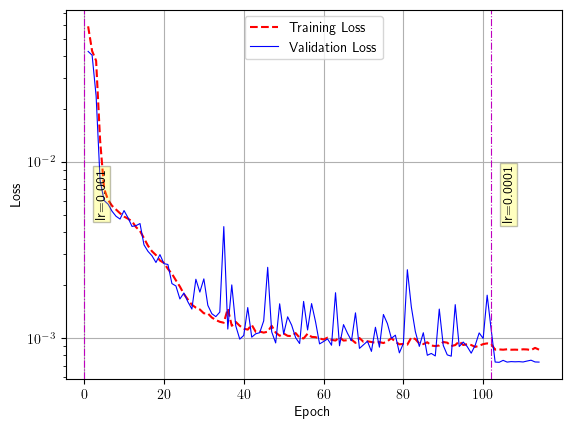

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

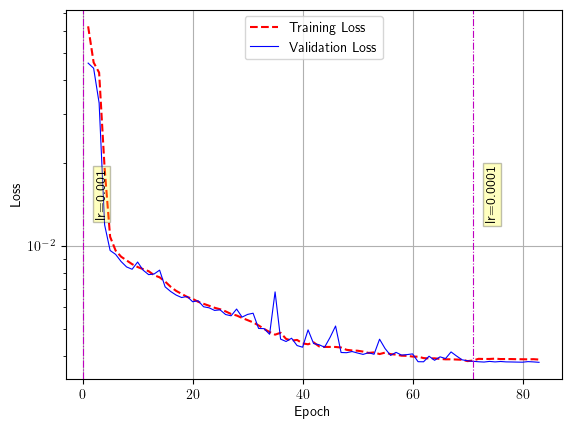

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

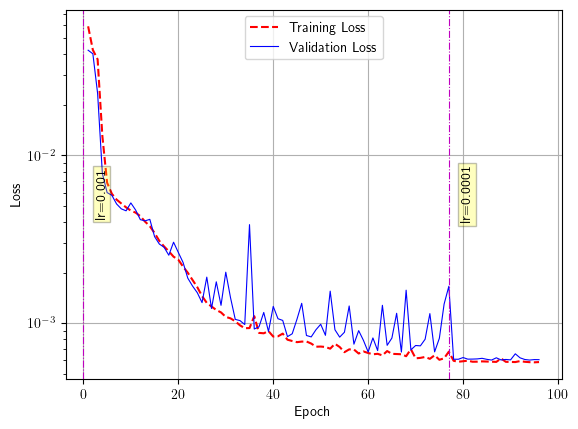

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

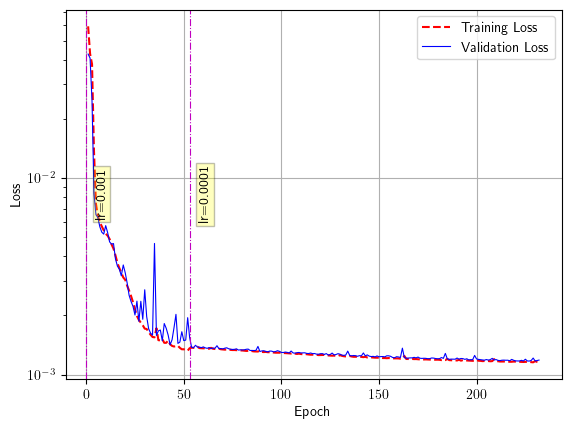

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

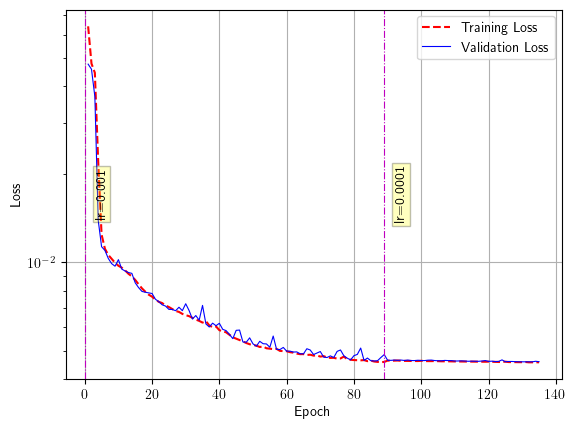

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

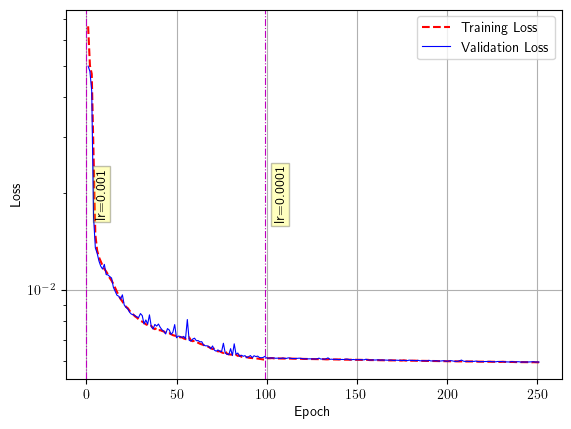

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

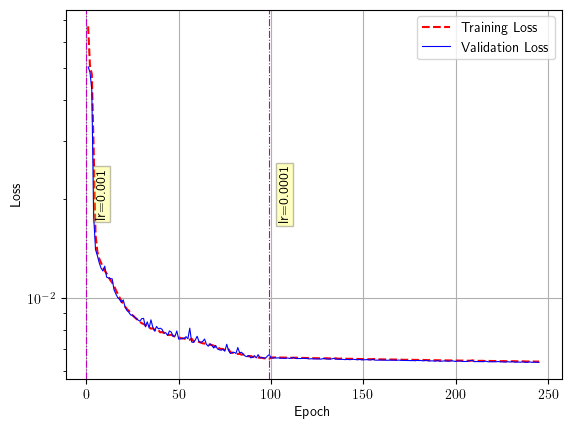

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

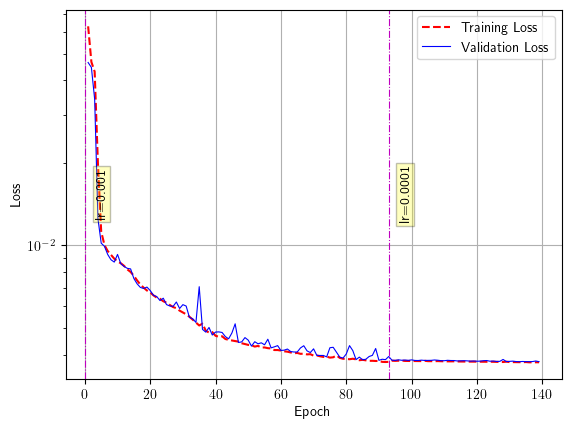

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

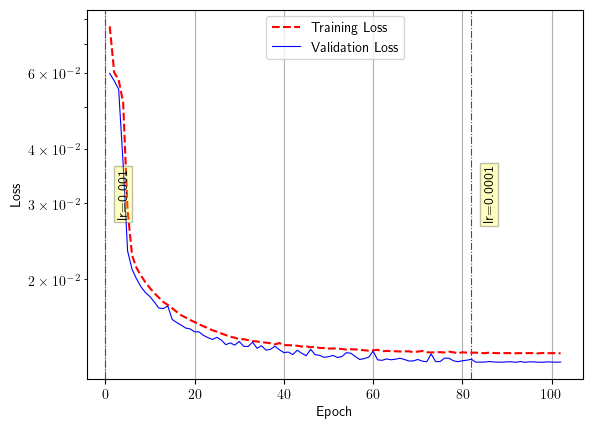

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

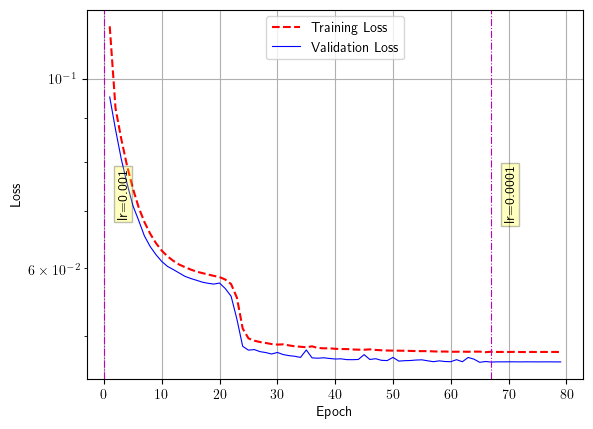

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

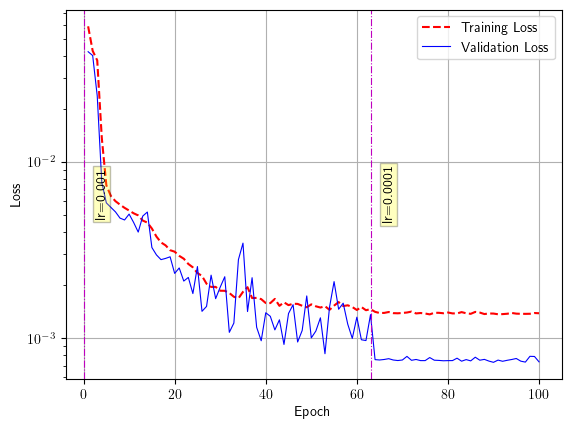

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

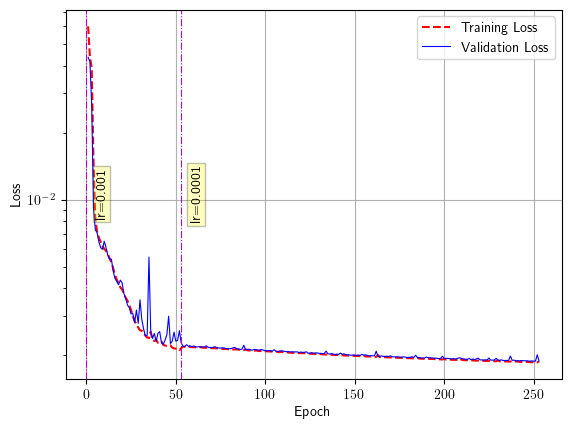

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

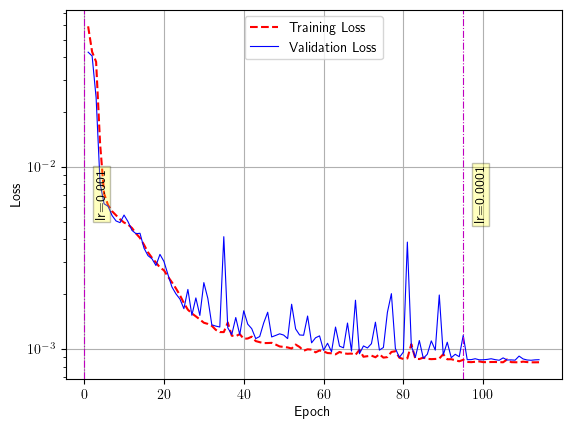

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

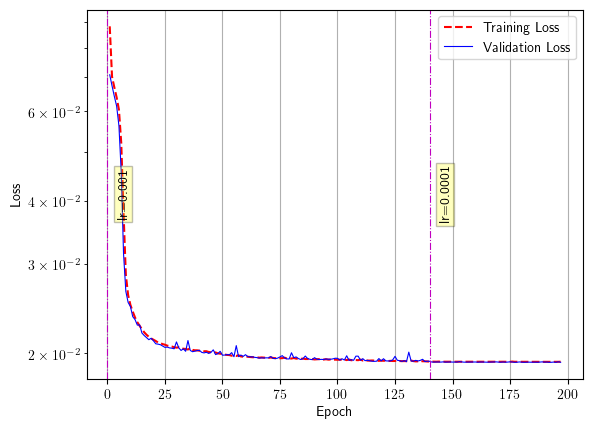

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

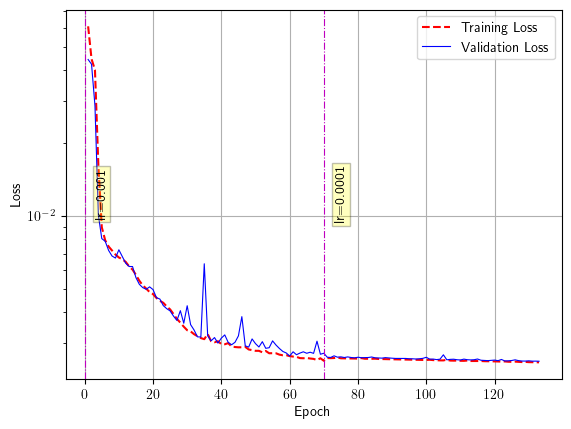

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

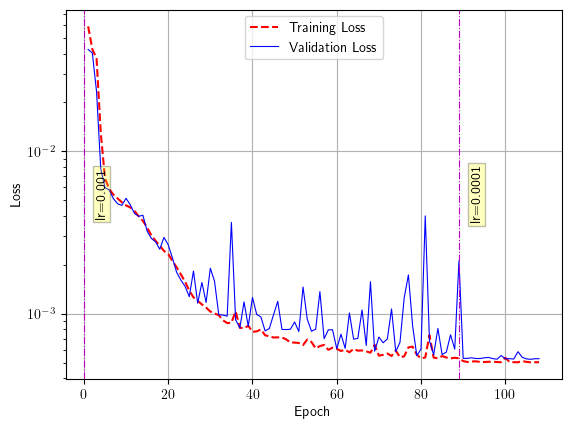

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

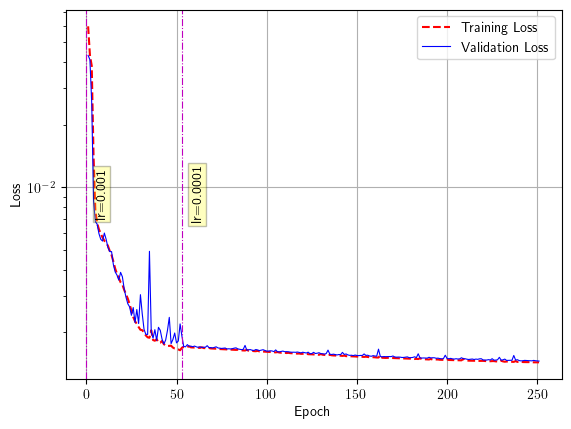

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

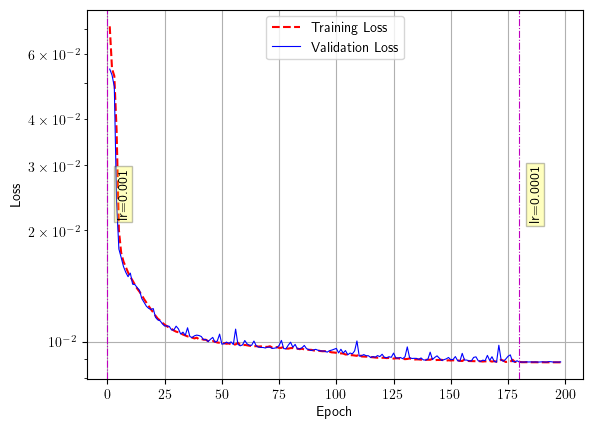

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

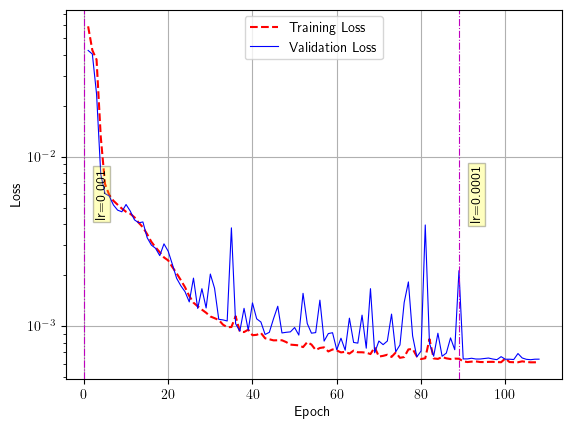

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

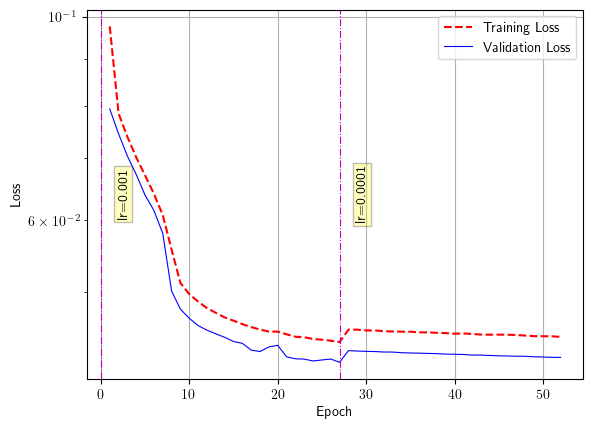

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

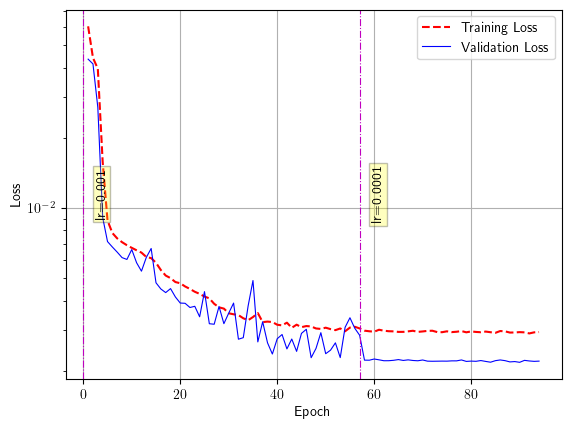

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

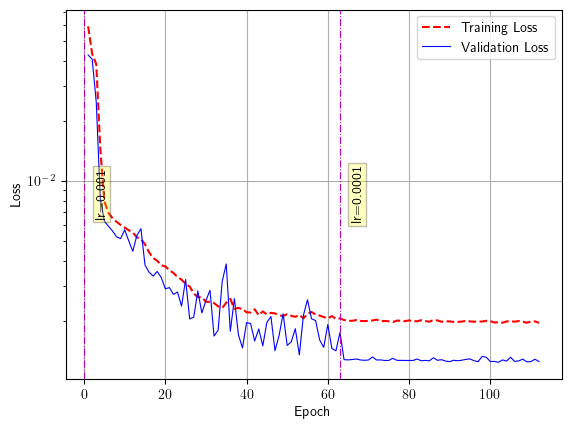

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

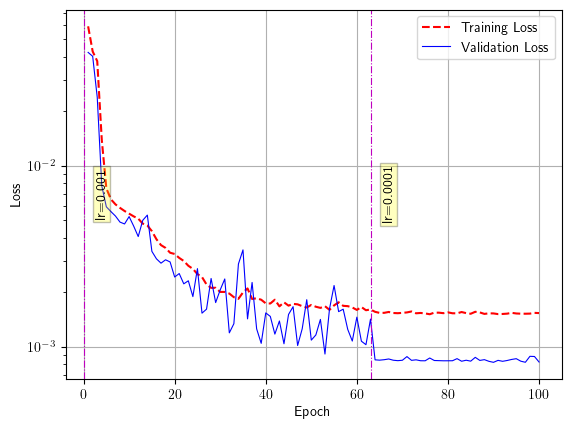

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

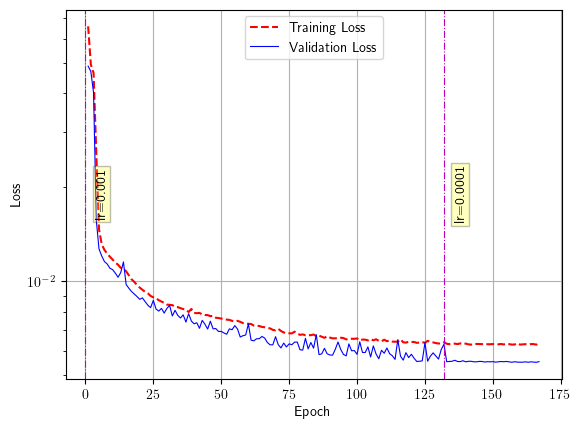

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

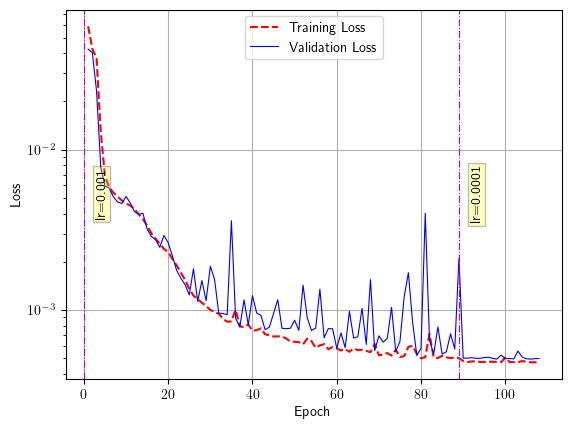

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
res = gp_minimize(
    optim_func,
    [fRMS_bounds, lambda_reg_bounds],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

In [37]:
res

          fun: 0.0004002771165687591
    func_vals: array([0.00045316, 0.00075789, 0.00043136, 0.00043872, 0.00073638,
       0.00085748, 0.00091754, 0.00065626, 0.00270147, 0.02610557,
       0.0006494 , 0.00051106, 0.00040757, 0.00298755, 0.0005966 ,
       0.0004013 , 0.00044883, 0.00099704, 0.00040533, 0.026465  ,
       0.00077458, 0.00067636, 0.00066305, 0.00095114, 0.00040028])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
         

In [38]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [39]:
optim_idx

24

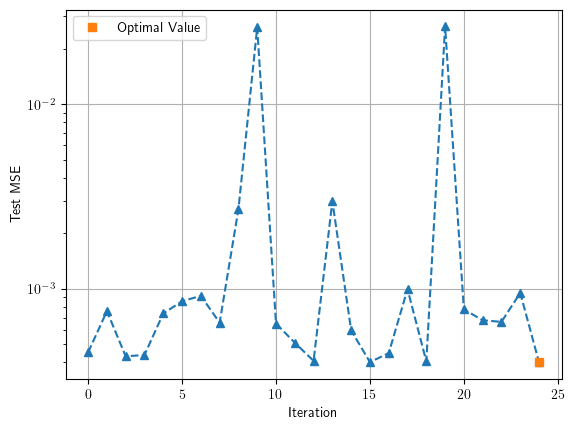

In [40]:
plt.semilogy(func_iters, '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('Test MSE')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/test_mse.png', bbox_inches='tight', dpi=300)
plt.show()

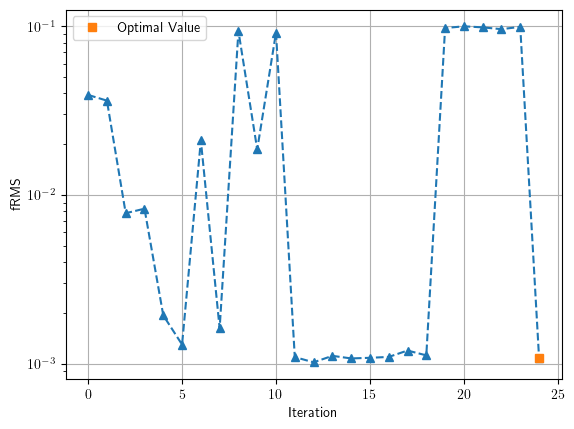

In [41]:
plt.semilogy(x_iters[:, 0], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel('fRMS')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/fRMS.png', bbox_inches='tight', dpi=300)
plt.show()

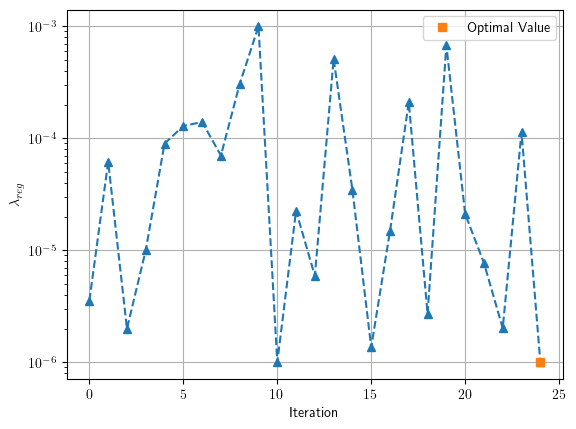

In [42]:
plt.semilogy(x_iters[:, 1], '--', marker='^', label='__nolegend__')
plt.semilogy([optim_idx], [x_iters[optim_idx, 1]], 's', label='Optimal Value')
plt.xlabel('Iteration')
plt.ylabel(r'$\lambda_{reg}$')
plt.grid(True)
plt.legend()

plt.savefig(dir_name_aensb_plots+'/lambda_reg.png', bbox_inches='tight', dpi=300)
plt.show()

In [43]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

# KE and Dissipation